In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Load data
df = pd.read_csv('data/ml_ready_data.csv')

print(f'✅ Data loaded: {len(df)} rows, {len(df.columns)} columns')
print(f'Period: {df["Rüblər"].iloc[0]} - {df["Rüblər"].iloc[-1]}')
print(f'NPLs range: {df["NPLs"].min():.0f} - {df["NPLs"].max():.0f}')

✅ Data loaded: 23 rows, 33 columns
Period: 2020 I - 2025 III
NPLs range: 13570 - 42223


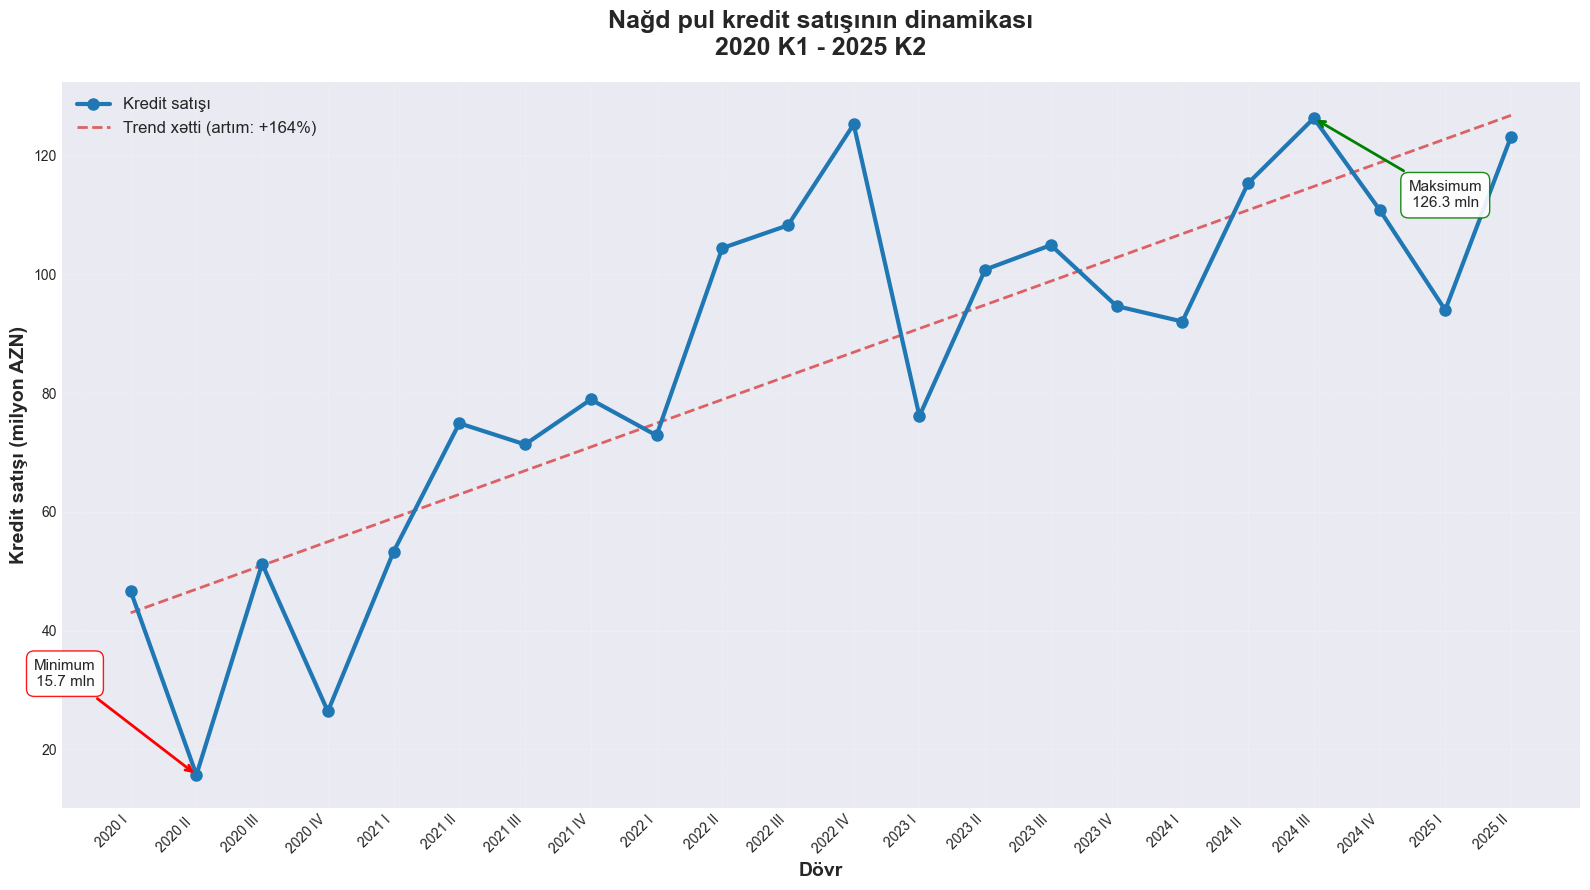

In [28]:
# Chart 1: Kredit Satışının Dinamikası
fig, ax = plt.subplots(figsize=(16, 9))

# Filter valid data
df_valid = df[df['Nağd_pul_kredit_satışı'].notna()].copy()

# Əsas xətt
ax.plot(range(len(df_valid)), df_valid['Nağd_pul_kredit_satışı']/1e6, 
        linewidth=3, marker='o', markersize=8, 
        color='#1f77b4', label='Kredit satışı', zorder=3)

# Trend xətti
growth_pct = ((df_valid["Nağd_pul_kredit_satışı"].iloc[-1]/df_valid["Nağd_pul_kredit_satışı"].iloc[0]-1)*100)
z = np.polyfit(range(len(df_valid)), df_valid['Nağd_pul_kredit_satışı']/1e6, 1)
p = np.poly1d(z)
ax.plot(range(len(df_valid)), p(range(len(df_valid))), 
        "--", linewidth=2, color='#d62728', 
        label=f'Trend xətti (artım: +{growth_pct:.0f}%)', 
        alpha=0.7, zorder=2)

# Şəbəkə və formatlaşdırma
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)
ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold')
ax.set_title('Nağd pul kredit satışının dinamikası\n2020 K1 - 2025 K2', 
            fontsize=18, fontweight='bold', pad=20)

# X oxu etiketləri
ax.set_xticks(range(len(df_valid)))
ax.set_xticklabels(df_valid['Rüblər'], rotation=45, ha='right')

# Legenda
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)

# Min/Max qeydlər
min_idx = df_valid['Nağd_pul_kredit_satışı'].idxmin()
max_idx = df_valid['Nağd_pul_kredit_satışı'].idxmax()
min_pos = df_valid.index.get_loc(min_idx)
max_pos = df_valid.index.get_loc(max_idx)

ax.annotate(f'Minimum\n{df_valid["Nağd_pul_kredit_satışı"].iloc[min_pos]/1e6:.1f} mln', 
           xy=(min_pos, df_valid['Nağd_pul_kredit_satışı'].iloc[min_pos]/1e6),
           xytext=(min_pos-2, df_valid['Nağd_pul_kredit_satışı'].iloc[min_pos]/1e6+15),
           fontsize=11, ha='center',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', alpha=0.9),
           arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.annotate(f'Maksimum\n{df_valid["Nağd_pul_kredit_satışı"].iloc[max_pos]/1e6:.1f} mln', 
           xy=(max_pos, df_valid['Nağd_pul_kredit_satışı'].iloc[max_pos]/1e6),
           xytext=(max_pos+2, df_valid['Nağd_pul_kredit_satışı'].iloc[max_pos]/1e6-15),
           fontsize=11, ha='center',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=0.9),
           arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.tight_layout()
plt.savefig('images/professional_01_sales_trend.png', dpi=200, bbox_inches='tight')
plt.show()



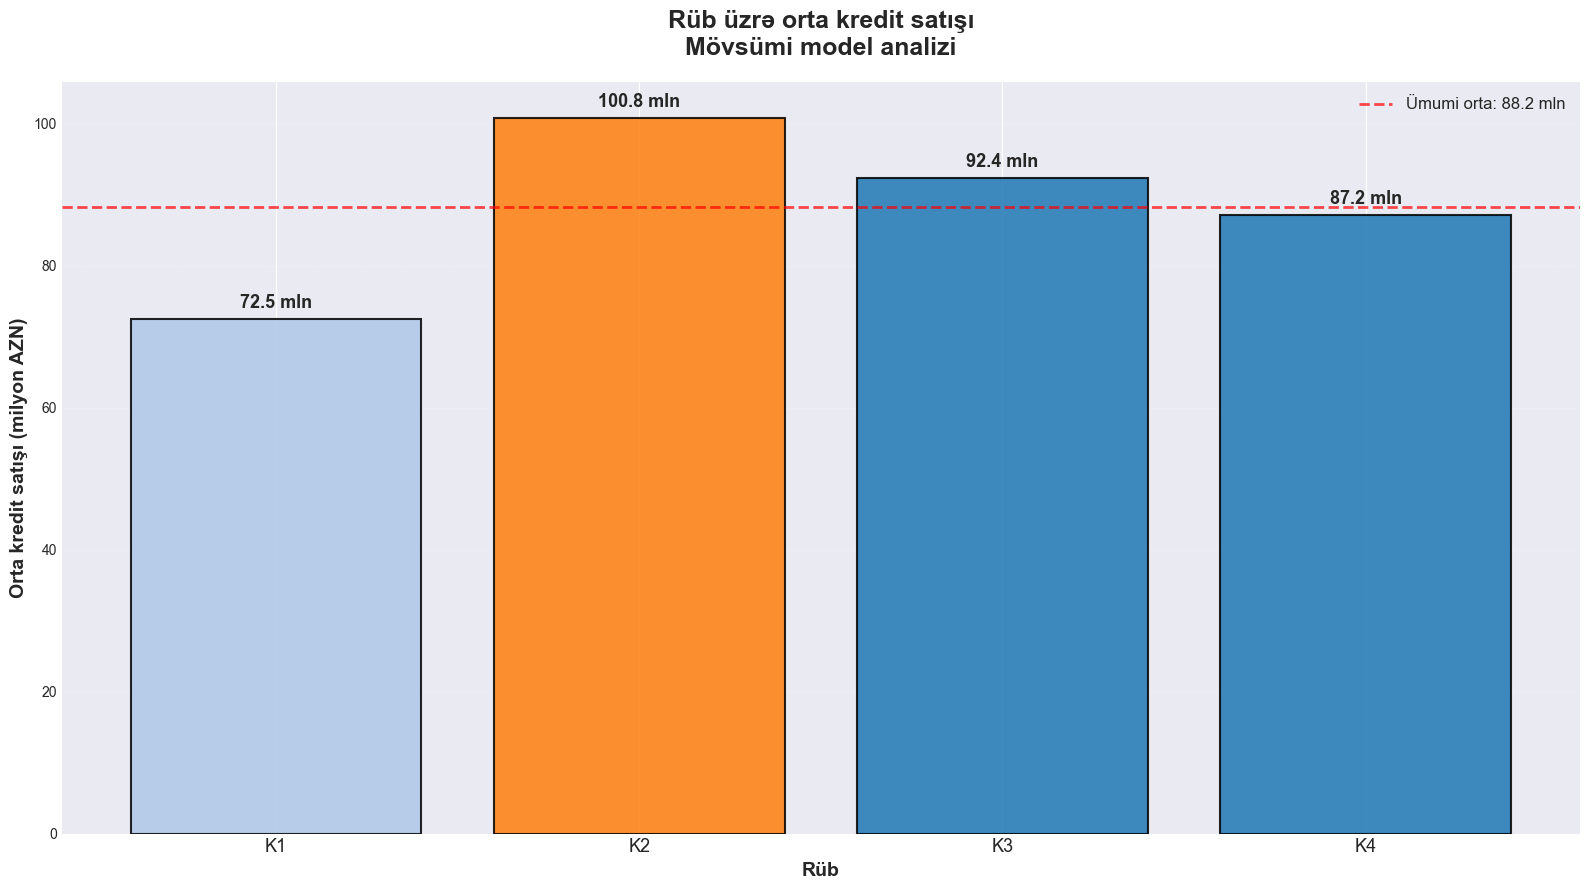

In [29]:
# Chart 2: Rüb üzrə Orta Satışlar (Mövsümi Model)
# Extract quarter from Rüblər column (Roman numerals)
df['Quarter_Label'] = df['Rüblər'].str.extract(r'([IVX]+)$')[0]

# Convert Roman numerals to K format
quarter_map = {'I': 'K1', 'II': 'K2', 'III': 'K3', 'IV': 'K4'}
df['Quarter_Label'] = df['Quarter_Label'].map(quarter_map)

quarterly_avg = df.groupby('Quarter_Label')['Nağd_pul_kredit_satışı'].mean()/1e6
quarterly_avg = quarterly_avg.reindex(['K1', 'K2', 'K3', 'K4'])

fig, ax = plt.subplots(figsize=(16, 9))

colors = ['#ff7f0e' if x == quarterly_avg.max() else '#aec7e8' if x == quarterly_avg.min() else '#1f77b4' 
          for x in quarterly_avg]

bars = ax.bar(range(len(quarterly_avg)), quarterly_avg, 
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

# Dəyər etiketləri
for i, (bar, val) in enumerate(zip(bars, quarterly_avg)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{val:.1f} mln',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.set_xlabel('Rüb', fontsize=14, fontweight='bold')
ax.set_ylabel('Orta kredit satışı (milyon AZN)', fontsize=14, fontweight='bold')
ax.set_title('Rüb üzrə orta kredit satışı\nMövsümi model analizi', 
            fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(range(len(quarterly_avg)))
ax.set_xticklabels(quarterly_avg.index, fontsize=13)
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.5)

# Orta xətt
mean_val = quarterly_avg.mean()
ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=2, 
          label=f'Ümumi orta: {mean_val:.1f} mln', alpha=0.7)
ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig('images/professional_02_quarterly_pattern.png', dpi=200, bbox_inches='tight')
plt.show()



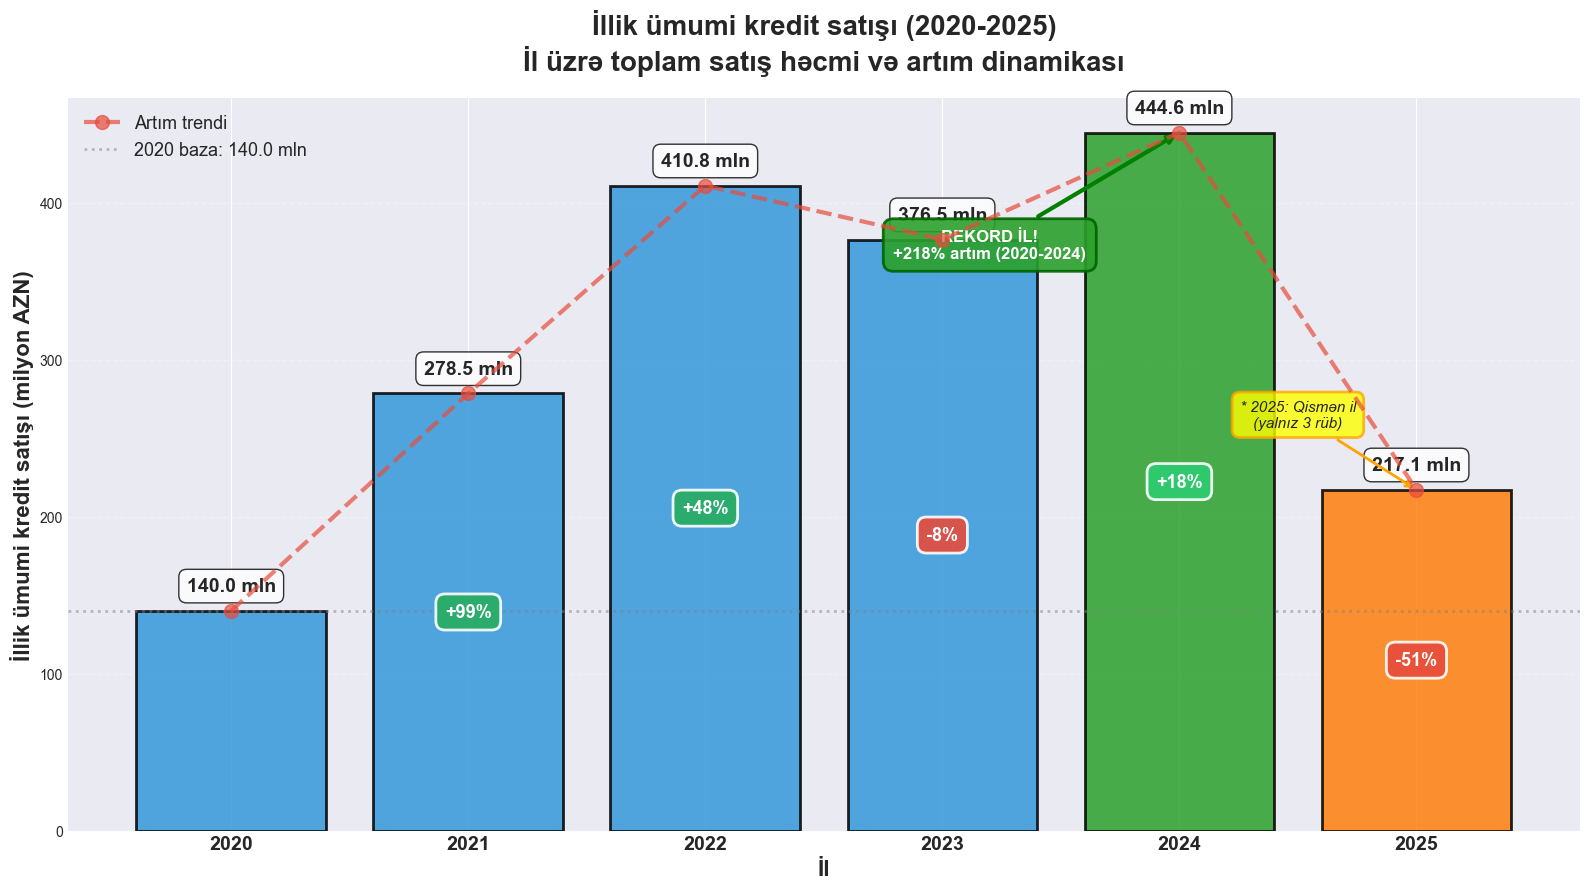

In [30]:
# Chart 3: İllik Ümumi Satışlar - İl üzrə Toplam
yearly_sum = df.groupby('Year')['Nağd_pul_kredit_satışı'].sum()/1e6

fig, ax = plt.subplots(figsize=(16, 9))

# Color scheme: green for complete years, orange for partial 2025
colors = []
for i, year in enumerate(yearly_sum.index):
    if year == 2025:
        colors.append('#ff7f0e')  # Orange for 2025 (partial)
    elif year == yearly_sum.idxmax():
        colors.append('#2ca02c')  # Bright green for record year
    else:
        colors.append('#3498db')  # Blue for other years

bars = ax.bar(range(len(yearly_sum)), yearly_sum, 
              color=colors, edgecolor='black', linewidth=2, alpha=0.85)

# Value labels on top of bars
for i, (bar, val) in enumerate(zip(bars, yearly_sum)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{val:.1f} mln',
            ha='center', va='bottom', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor='black', alpha=0.8))

# Growth percentage labels inside bars
for i in range(1, len(yearly_sum)):
    growth = ((yearly_sum.iloc[i] / yearly_sum.iloc[i-1]) - 1) * 100
    y_pos = yearly_sum.iloc[i]/2
    
    # Color based on growth rate
    if growth > 25:
        bg_color = '#27ae60'  # Strong green
    elif growth > 15:
        bg_color = '#2ecc71'  # Green
    elif growth > 0:
        bg_color = '#f39c12'  # Orange
    else:
        bg_color = '#e74c3c'  # Red
    
    ax.text(i, y_pos, f'{growth:+.0f}%',
            ha='center', va='center', fontsize=13, fontweight='bold',
            color='white', bbox=dict(boxstyle='round,pad=0.5', 
                                    facecolor=bg_color, alpha=0.9, linewidth=2,
                                    edgecolor='white'))

# Trend line connecting bar tops
x_pos = range(len(yearly_sum))
ax.plot(x_pos, yearly_sum, color='#e74c3c', linewidth=3, 
        marker='o', markersize=10, linestyle='--', 
        alpha=0.7, label='Artım trendi', zorder=10)

ax.set_xlabel('İl', fontsize=16, fontweight='bold')
ax.set_ylabel('İllik ümumi kredit satışı (milyon AZN)', fontsize=16, fontweight='bold')
ax.set_title('İllik ümumi kredit satışı (2020-2025)\nİl üzrə toplam satış həcmi və artım dinamikası', 
            fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(range(len(yearly_sum)))
ax.set_xticklabels(yearly_sum.index.astype(str), fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1)

# Add baseline at starting value
ax.axhline(y=yearly_sum.iloc[0], color='gray', linestyle=':', 
          linewidth=2, alpha=0.5, label=f'2020 baza: {yearly_sum.iloc[0]:.1f} mln')

# Legend
ax.legend(loc='upper left', fontsize=13, framealpha=0.95)

# Annotation for 2025 (partial year)
quarters_2025 = len(df[df['Year'] == 2025])
ax.annotate(f'* 2025: Qismən il\n(yalnız {quarters_2025} rüb)',
           xy=(len(yearly_sum)-1, yearly_sum.iloc[-1]),
           xytext=(len(yearly_sum)-1.5, yearly_sum.iloc[-1]+40),
           fontsize=11, ha='center', style='italic',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                    edgecolor='orange', alpha=0.8, linewidth=2),
           arrowprops=dict(arrowstyle='->', color='orange', lw=2))

# Annotation for record year
record_idx = yearly_sum[:-1].idxmax()  # Exclude 2025 from record
record_pos = list(yearly_sum.index).index(record_idx)
total_growth = ((yearly_sum.iloc[-2]/yearly_sum.iloc[0]-1)*100)  # 2020 to 2024

ax.annotate(f'REKORD İL!\n+{total_growth:.0f}% artım (2020-2024)',
           xy=(record_pos, yearly_sum.iloc[record_pos]),
           xytext=(record_pos-0.8, yearly_sum.iloc[record_pos]-80),
           fontsize=12, ha='center', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.6', facecolor='#2ca02c', 
                    edgecolor='darkgreen', alpha=0.9, linewidth=2),
           color='white',
           arrowprops=dict(arrowstyle='->', color='green', lw=3))

plt.tight_layout()
plt.savefig('images/professional_03_yearly_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

# Calculate and print statistics
growth_total = ((yearly_sum.iloc[-2]/yearly_sum.iloc[0]-1)*100)  # Use 2024 as last complete year

# Find year with highest growth
max_growth_idx = 0
max_growth = 0
for i in range(1, len(yearly_sum)):
    growth = ((yearly_sum.iloc[i] / yearly_sum.iloc[i-1]) - 1) * 100
    if growth > max_growth:
        max_growth = growth
        max_growth_idx = i



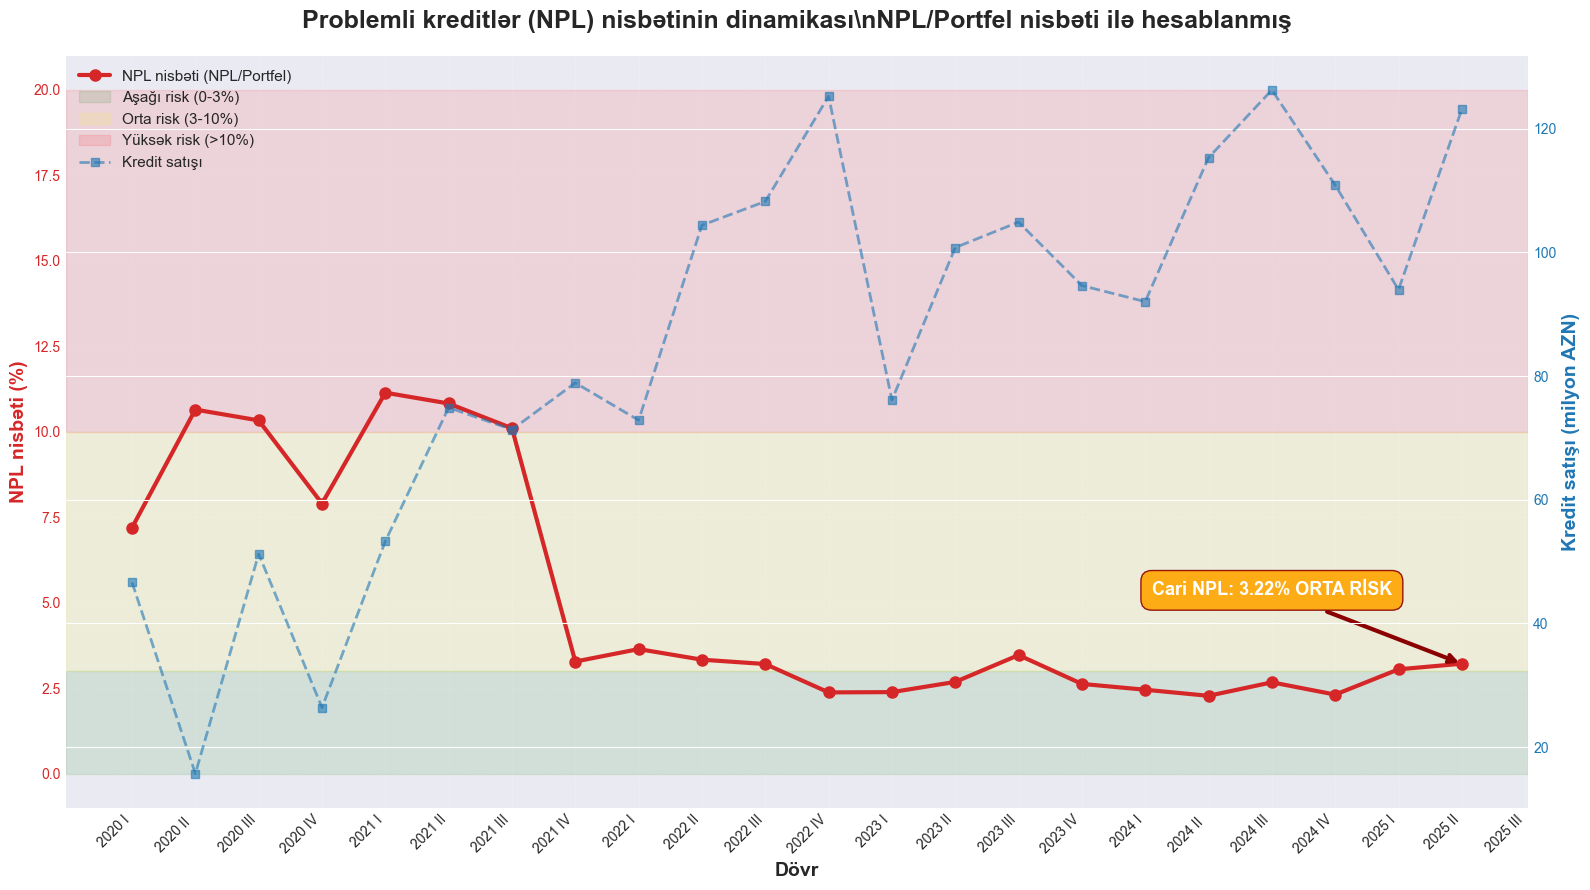

In [31]:
# Chart 4: NPL Nisbətinin Dinamikası
# Calculate NPL percentage as NPLs / Portfolio * 100
df['NPL_percentage'] = (df['NPLs'] / df['Portfel']) * 100

fig, ax1 = plt.subplots(figsize=(16, 9))

# NPL xətti (calculated as NPLs/Portfolio)
color = '#d62728'
ax1.plot(range(len(df)), df['NPL_percentage'], 
        linewidth=3, marker='o', markersize=8, 
        color=color, label='NPL nisbəti (NPL/Portfel)', zorder=3)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('NPL nisbəti (%)', fontsize=14, fontweight='bold', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Risk zonaları
ax1.axhspan(0, 3, alpha=0.1, color='green', label='Aşağı risk (0-3%)')
ax1.axhspan(3, 10, alpha=0.1, color='yellow', label='Orta risk (3-10%)')
ax1.axhspan(10, 20, alpha=0.1, color='red', label='Yüksək risk (>10%)')

# Kredit satışı (ikinci ox)
ax2 = ax1.twinx()
color2 = '#1f77b4'
ax2.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=2, marker='s', markersize=6, 
        color=color2, alpha=0.6, label='Kredit satışı', linestyle='--', zorder=2)
ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Başlıq
ax1.set_title('Problemli kreditlər (NPL) nisbətinin dinamikası\\nNPL/Portfel nisbəti ilə hesablanmış', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95)

# Cari NPL qeydi (use valid data)
df_npl_valid = df[df['NPL_percentage'].notna()]
current_npl = df_npl_valid['NPL_percentage'].iloc[-1]
current_pos = len(df_npl_valid) - 1

# Determine risk status
if current_npl > 10:
    risk_status = 'TƏHLÜKƏLI YÜKSƏK!'
    risk_color = 'red'
elif current_npl > 3:
    risk_status = 'ORTA RİSK'
    risk_color = 'orange'
else:
    risk_status = 'AŞAĞI RİSK'
    risk_color = 'green'

ax1.annotate(f'Cari NPL: {current_npl:.2f}% {risk_status}', 
            xy=(current_pos, current_npl),
            xytext=(current_pos-3, current_npl+2),
            fontsize=13, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round,pad=0.6', facecolor=risk_color, 
                     edgecolor='darkgreen' if risk_color=='green' else 'darkred', alpha=0.9),
            color='white',
            arrowprops=dict(arrowstyle='->', 
                          color='darkgreen' if risk_color=='green' else 'darkred', lw=3))

# Add calculation details
current_npl_amount = df_npl_valid['NPLs'].iloc[-1] / 1e6
current_portfolio = df_npl_valid['Portfel'].iloc[-1] / 1e6


plt.tight_layout()
plt.savefig('images/professional_04_npl_trend.png', dpi=200, bbox_inches='tight')
plt.show()



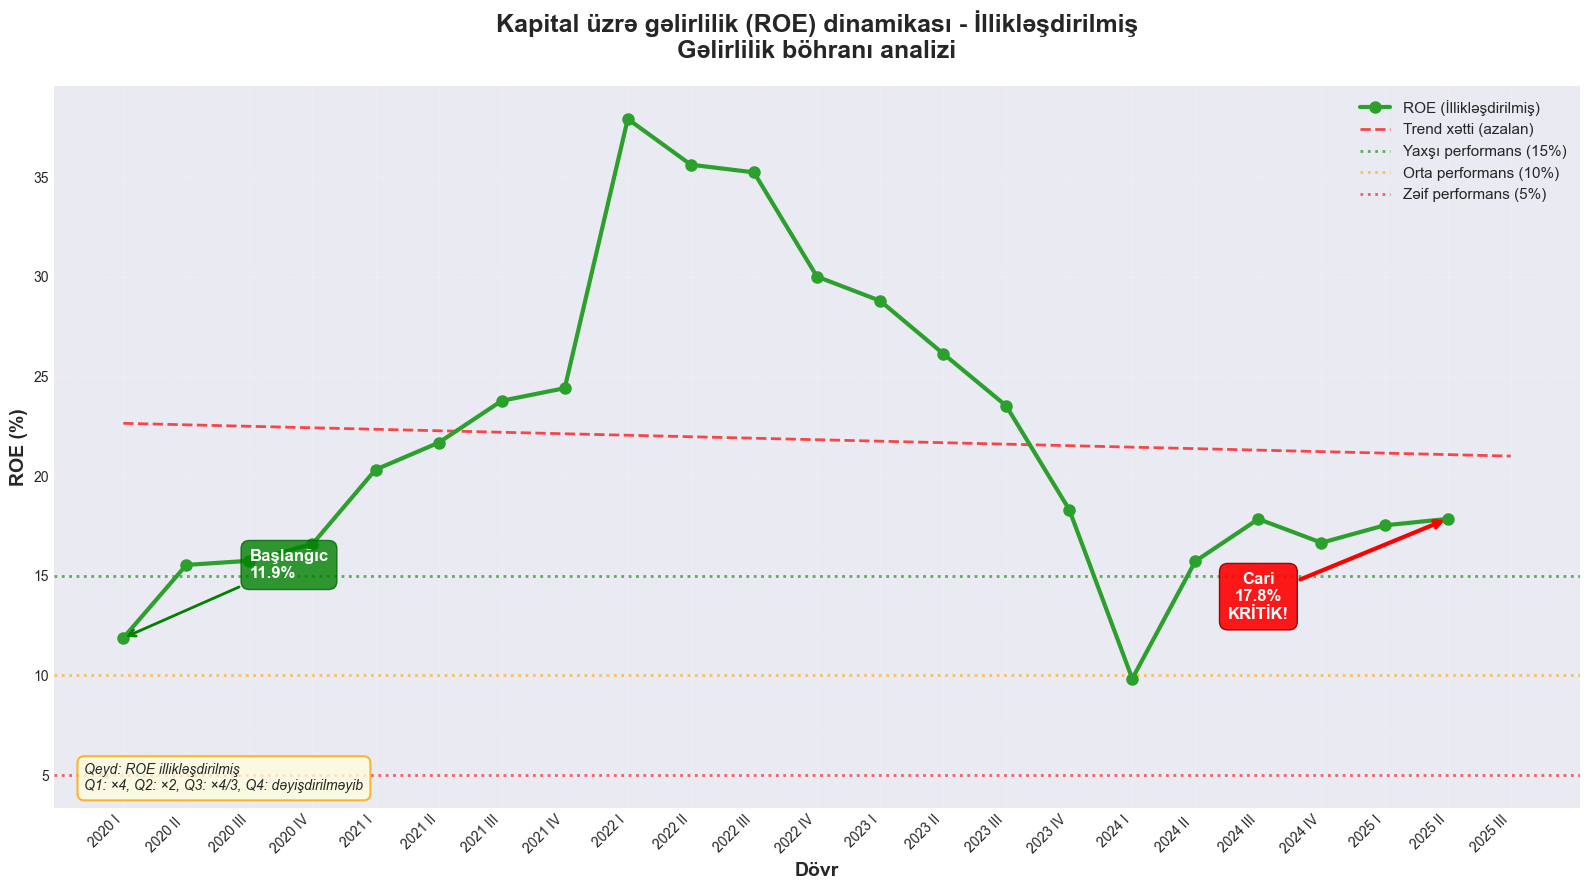

In [32]:
# Chart 5: ROE Dinamikası (Annualized)
# Annualize ROE based on quarter
# Q1: multiply by 4, Q2: multiply by 2, Q3: multiply by 4/3, Q4: no change

df['ROE_annualized'] = df['ROE'].copy()

for idx in df.index:
    quarter = df.loc[idx, 'Quarter']
    roe = df.loc[idx, 'ROE']
    
    if pd.notna(roe) and pd.notna(quarter):
        if quarter == 1:  # Q1
            df.loc[idx, 'ROE_annualized'] = roe * 4
        elif quarter == 2:  # Q2
            df.loc[idx, 'ROE_annualized'] = roe * 2
        elif quarter == 3:  # Q3
            df.loc[idx, 'ROE_annualized'] = roe * (4/3)
        # Q4 stays as is

fig, ax = plt.subplots(figsize=(16, 9))

# ROE xətti (annualized)
ax.plot(range(len(df)), df['ROE_annualized']*100, 
        linewidth=3, marker='o', markersize=8, 
        color='#2ca02c', label='ROE (İllikləşdirilmiş)', zorder=3)

# Trend xətti
df_roe_valid = df[df['ROE_annualized'].notna()]
z = np.polyfit(range(len(df_roe_valid)), df_roe_valid['ROE_annualized']*100, 1)
p = np.poly1d(z)
ax.plot(range(len(df)), p(range(len(df))), 
        "--", linewidth=2, color='red', 
        label='Trend xətti (azalan)', alpha=0.7, zorder=2)

ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('ROE (%)', fontsize=14, fontweight='bold')
ax.set_title('Kapital üzrə gəlirlilik (ROE) dinamikası - İllikləşdirilmiş\nGəlirlilik böhranı analizi', 
            fontsize=18, fontweight='bold', pad=20)

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Benchmark xətləri
ax.axhline(y=15, color='green', linestyle=':', linewidth=2, 
          label='Yaxşı performans (15%)', alpha=0.6)
ax.axhline(y=10, color='orange', linestyle=':', linewidth=2, 
          label='Orta performans (10%)', alpha=0.6)
ax.axhline(y=5, color='red', linestyle=':', linewidth=2, 
          label='Zəif performans (5%)', alpha=0.6)

ax.legend(loc='upper right', fontsize=11, framealpha=0.95)

# Başlanğıc və son nöqtələr
start_roe = df['ROE_annualized'].iloc[0] * 100
end_roe = df_roe_valid['ROE_annualized'].iloc[-1] * 100

ax.annotate(f'Başlanğıc\n{start_roe:.1f}%', 
           xy=(0, start_roe),
           xytext=(2, start_roe+3),
           fontsize=12, fontweight='bold', ha='left',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='green', edgecolor='darkgreen', alpha=0.8),
           color='white',
           arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax.annotate(f'Cari\n{end_roe:.1f}%\nKRİTİK!', 
           xy=(len(df_roe_valid)-1, end_roe),
           xytext=(len(df)-5, end_roe-5),
           fontsize=12, fontweight='bold', ha='center',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='red', edgecolor='darkred', alpha=0.9),
           color='white',
           arrowprops=dict(arrowstyle='->', color='red', lw=3))

# Add annualization note
ax.text(0.02, 0.02, 
        'Qeyd: ROE illikləşdirilmiş\nQ1: ×4, Q2: ×2, Q3: ×4/3, Q4: dəyişdirilməyib',
        transform=ax.transAxes, fontsize=10, style='italic',
        ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                 edgecolor='orange', alpha=0.8, linewidth=1.5))

plt.tight_layout()
plt.savefig('images/professional_05_roe_trend.png', dpi=200, bbox_inches='tight')
plt.show()

roe_change = ((end_roe/start_roe-1)*100)


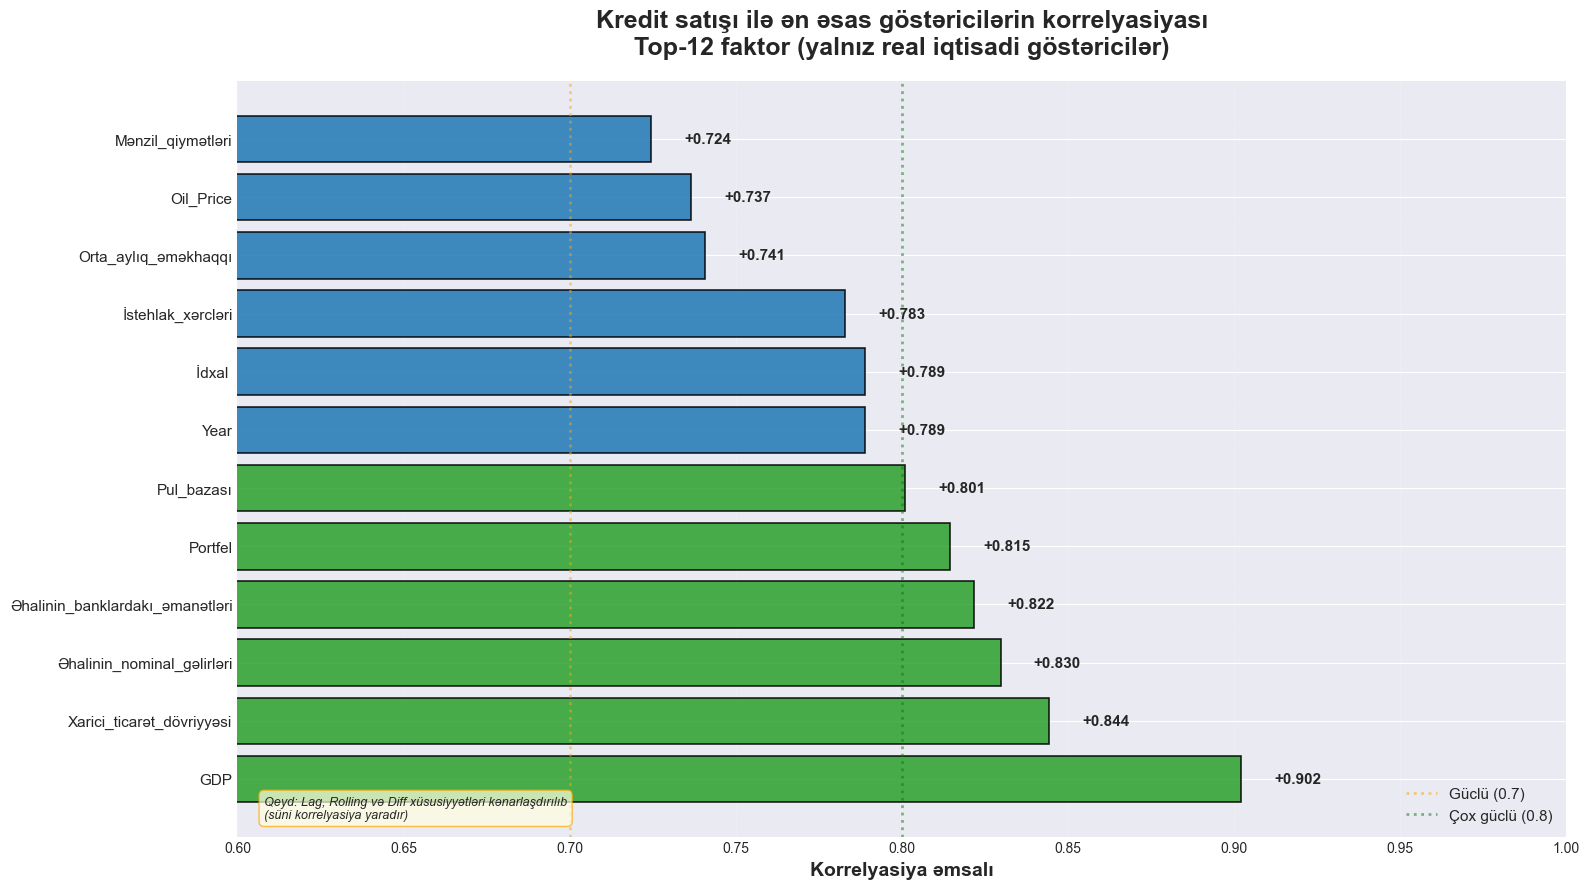

In [33]:
# Chart 6: Top-12 Korrelyasiya
# Kredit satışı ilə korrelyasiya hesablama

# EXCLUDE engineered features that cause fake multicollinearity
exclude_cols = [
    'Nağd_pul_kredit_satışı',  # Target itself
    'Kumulyativ_satish',  # Cumulative target
    'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',  # Lag features
    'Rolling_Mean_2', 'Rolling_Mean_3', 'Rolling_Mean_4',  # Rolling means
    'Rolling_Std_2', 'Rolling_Std_3', 'Rolling_Std_4',  # Rolling stds
    'Diff_1', 'Diff_4',  # Difference features
    'Time_Index',  # Just a counter
]

# Get numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Filter out excluded columns
valid_cols = [col for col in numeric_cols if col not in exclude_cols]

# Calculate correlations only for valid columns
correlations = df[valid_cols].corrwith(df['Nağd_pul_kredit_satışı']).sort_values(ascending=False)

# Top-12 götür
top_12 = correlations.head(12)

fig, ax = plt.subplots(figsize=(16, 9))

colors = ['#2ca02c' if x > 0.8 else '#1f77b4' if x > 0.7 else '#ff7f0e' for x in top_12]
bars = ax.barh(range(len(top_12)), top_12, color=colors, 
               edgecolor='black', linewidth=1.2, alpha=0.85)

# Dəyər etiketləri
for i, (bar, val) in enumerate(zip(bars, top_12)):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
            f'{val:+.3f}',
            ha='left', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Korrelyasiya əmsalı', fontsize=14, fontweight='bold')
ax.set_title('Kredit satışı ilə ən əsas göstəricilərin korrelyasiyası\nTop-12 faktor (yalnız real iqtisadi göstəricilər)', 
            fontsize=18, fontweight='bold', pad=20)
ax.set_yticks(range(len(top_12)))
ax.set_yticklabels(top_12.index, fontsize=11)
ax.grid(True, alpha=0.3, axis='x', linestyle='--', linewidth=0.5)
ax.set_xlim([0.6, 1.0])

# Referans xətləri
ax.axvline(x=0.7, color='orange', linestyle=':', linewidth=2, alpha=0.5, label='Güclü (0.7)')
ax.axvline(x=0.8, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Çox güclü (0.8)')
ax.legend(loc='lower right', fontsize=11)

# Add note about excluded features
ax.text(0.02, 0.02, 
        'Qeyd: Lag, Rolling və Diff xüsusiyyətləri kənarlaşdırılıb\n(süni korrelyasiya yaradır)',
        transform=ax.transAxes, fontsize=9, style='italic',
        ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', 
                 edgecolor='orange', alpha=0.7))

plt.tight_layout()
plt.savefig('images/professional_06_correlations.png', dpi=200, bbox_inches='tight')
plt.show()



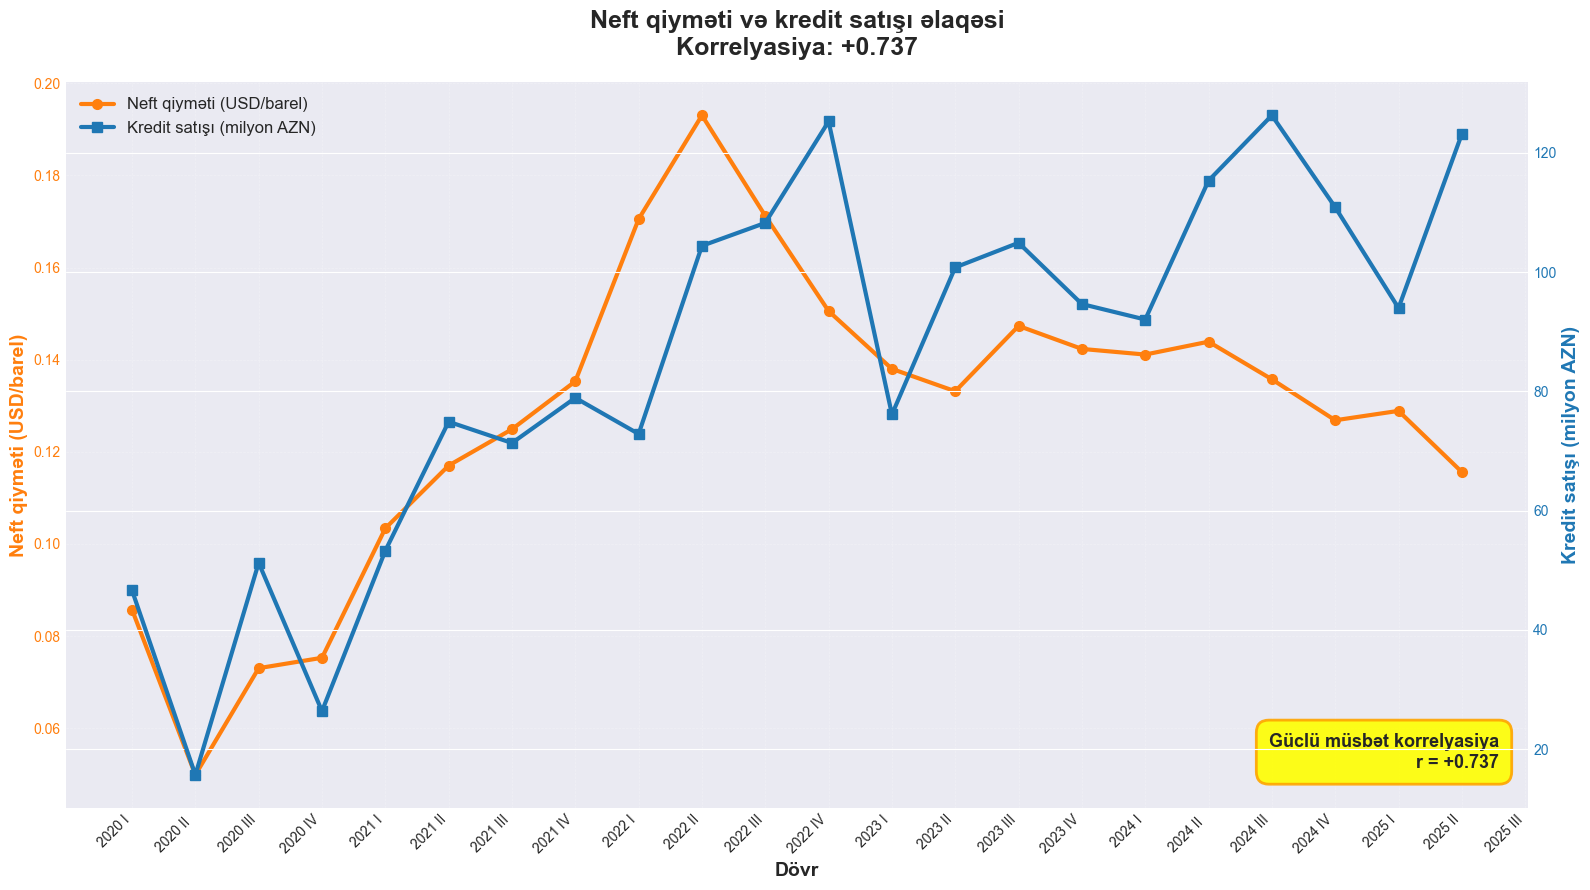

In [34]:
# Chart 7: Neft Qiyməti vs Kredit Satışı
fig, ax1 = plt.subplots(figsize=(16, 9))

# Neft qiyməti
color = '#ff7f0e'
ax1.plot(range(len(df)), df['Oil_Price'], 
        linewidth=3, marker='o', markersize=7, 
        color=color, label='Neft qiyməti (USD/barel)', zorder=3)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Neft qiyməti (USD/barel)', fontsize=14, fontweight='bold', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Kredit satışı (ikinci ox)
ax2 = ax1.twinx()
color2 = '#1f77b4'
ax2.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=3, marker='s', markersize=7, 
        color=color2, label='Kredit satışı (milyon AZN)', zorder=3)
ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Başlıq
oil_credit_corr = df['Oil_Price'].corr(df['Nağd_pul_kredit_satışı'])
ax1.set_title(f'Neft qiyməti və kredit satışı əlaqəsi\nKorrelyasiya: {oil_credit_corr:+.3f}', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Korrelyasiya qeydi
ax1.text(0.98, 0.05, f'Güclü müsbət korrelyasiya\nr = {oil_credit_corr:+.3f}',
        transform=ax1.transAxes, fontsize=13, fontweight='bold',
        ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', edgecolor='orange', 
                 alpha=0.9, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_07_oil_sales.png', dpi=200, bbox_inches='tight')
plt.show()



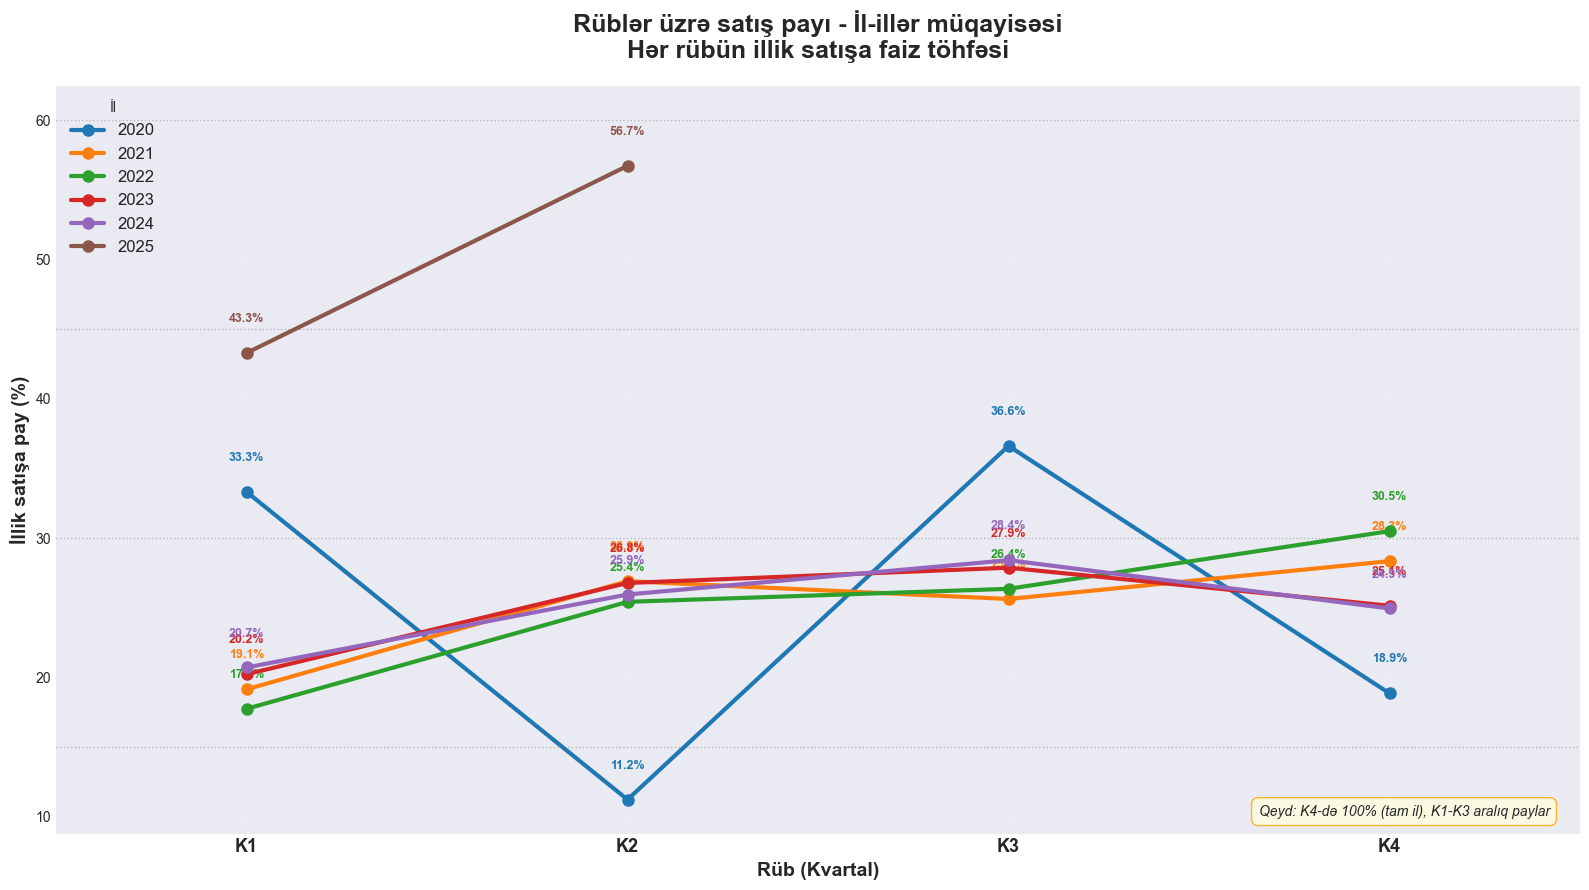

In [35]:
# Chart 8: Rüblər üzrə Satış Payı - İllik Dinamika
# Calculate quarterly sales as percentage of yearly cumulative sales

fig, ax = plt.subplots(figsize=(16, 9))

# Define colors for each year
year_colors = {
    2020: '#1f77b4',
    2021: '#ff7f0e', 
    2022: '#2ca02c',
    2023: '#d62728',
    2024: '#9467bd',
    2025: '#8c564b'
}

# Plot each year
for year in df['Year'].dropna().unique():
    if pd.notna(year):
        year = int(year)
        year_data = df[df['Year'] == year].copy()
        
        # Get full year total (Q4 cumulative sales for this year)
        year_total = year_data['Kumulyativ_satish'].max()
        
        # Calculate percentage: (Quarterly Sales / Full Year Total) * 100
        year_data['Sales_Percentage'] = (year_data['Nağd_pul_kredit_satışı'] / year_total) * 100
        # Sort by quarter
        year_data = year_data.sort_values('Quarter')
        
        # Plot line for this year
        quarters = year_data['Quarter'].values
        percentages = year_data['Sales_Percentage'].values
        
        ax.plot(quarters, percentages, 
                marker='o', markersize=8, linewidth=3,
                color=year_colors.get(year, '#333333'),
                label=f'{year}', zorder=3)
        
        # Add value labels
        for q, p in zip(quarters, percentages):
            if pd.notna(p):
                ax.text(q, p + 2, f'{p:.1f}%',
                       ha='center', va='bottom', fontsize=9,
                       fontweight='bold', color=year_colors.get(year, '#333333'))

# Formatting
ax.set_xlabel('Rüb (Kvartal)', fontsize=14, fontweight='bold')
ax.set_ylabel('İllik satışa pay (%)', fontsize=14, fontweight='bold')
ax.set_title('Rüblər üzrə satış payı - İl-illər müqayisəsi\nHər rübün illik satışa faiz töhfəsi', 
            fontsize=18, fontweight='bold', pad=20)

# Set x-axis
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['K1', 'K2', 'K3', 'K4'], fontsize=13, fontweight='bold')
ax.set_xlim([0.5, 4.5])

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Legend
ax.legend(loc='upper left', fontsize=12, framealpha=0.95, title='İl')

# Add horizontal reference lines
ax.axhline(y=15, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='15%')
ax.axhline(y=30, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='30%')
ax.axhline(y=45, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='45%')
ax.axhline(y=60, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='60%')

# Add note
ax.text(0.98, 0.02, 
        'Qeyd: K4-də 100% (tam il), K1-K3 aralıq paylar',
        transform=ax.transAxes, fontsize=10, style='italic',
        ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                 edgecolor='orange', alpha=0.8))

plt.tight_layout()
plt.savefig('images/professional_08_quarterly_share.png', dpi=200, bbox_inches='tight')
plt.show()

# Calculate average shares by quarter
# avg_q1 = df[df['Quarter'] == 1]['Nağd_pul_kredit_satışı'].sum() / df[df['Quarter'] == 1]['Kumulyativ_satish'].sum() * 100 if len(df[df['Quarter'] == 1]) > 0 else 0
# avg_q2 = df[df['Quarter'] == 2]['Nağd_pul_kredit_satışı'].sum() / df[df['Quarter'] == 2]['Kumulyativ_satish'].sum() * 100 if len(df[df['Quarter'] == 2]) > 0 else 0
# avg_q3 = df[df['Quarter'] == 3]['Nağd_pul_kredit_satışı'].sum() / df[df['Quarter'] == 3]['Kumulyativ_satish'].sum() * 100 if len(df[df['Quarter'] == 3]) > 0 else 0

# print(f"✅ Chart 8 yaradıldı: Rüblər üzrə satış payı")
# print(f"   Orta paylar - K1: {avg_q1:.1f}%, K2: {avg_q2:.1f}%, K3: {avg_q3:.1f}%")

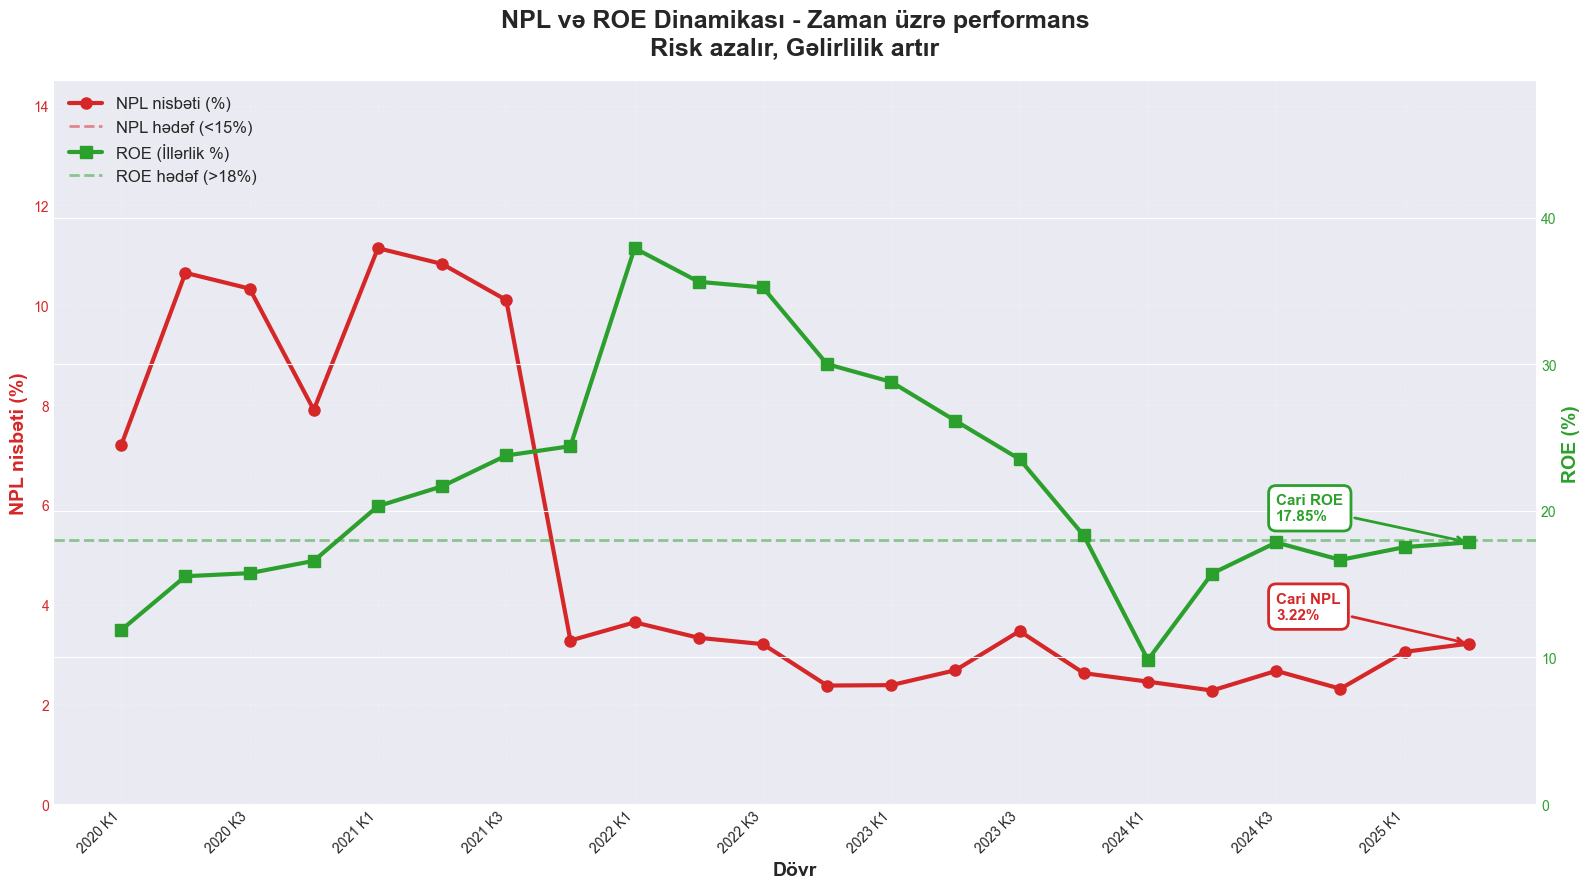

In [36]:
# Chart 9: NPL və ROE Dinamikası
fig, ax1 = plt.subplots(figsize=(16, 9))

# Filter valid data
df_perf = df[df['NPL_percentage'].notna() & df['ROE'].notna()].copy()
df_perf = df_perf.sort_values('Rüblər')

# Annualize ROE based on quarter
df_perf['ROE_annualized'] = df_perf['ROE'].copy()
for idx_row in df_perf.index:
    quarter = df_perf.loc[idx_row, 'Quarter']
    roe = df_perf.loc[idx_row, 'ROE']
    if pd.notna(roe) and pd.notna(quarter):
        if quarter == 1:
            df_perf.loc[idx_row, 'ROE_annualized'] = roe * 4
        elif quarter == 2:
            df_perf.loc[idx_row, 'ROE_annualized'] = roe * 2
        elif quarter == 3:
            df_perf.loc[idx_row, 'ROE_annualized'] = roe * (4/3)

# Create time labels
time_labels = []
for _, row in df_perf.iterrows():
    if pd.notna(row['Year']) and pd.notna(row['Quarter']):
        time_labels.append(f"{int(row['Year'])} K{int(row['Quarter'])}")
    else:
        time_labels.append('')

x_pos = range(len(df_perf))

# Plot NPL on first y-axis (left)
color_npl = '#d62728'
ax1.plot(x_pos, df_perf['NPL_percentage'], color=color_npl, linewidth=3, marker='o', markersize=8, label='NPL nisbəti (%)', zorder=3)
ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('NPL nisbəti (%)', fontsize=14, fontweight='bold', color=color_npl)
ax1.tick_params(axis='y', labelcolor=color_npl)
ax1.set_ylim([0, max(df_perf['NPL_percentage']) * 1.3])

# Add NPL target line
ax1.axhline(y=15, color=color_npl, linestyle='--', linewidth=2, alpha=0.5, label='NPL hədəf (<15%)')

# Create second y-axis for ROE
ax2 = ax1.twinx()
color_roe = '#2ca02c'
ax2.plot(x_pos, df_perf['ROE_annualized']*100, color=color_roe, linewidth=3, marker='s', markersize=8, label='ROE (İllərlik %)', zorder=3)
ax2.set_ylabel('ROE (%)', fontsize=14, fontweight='bold', color=color_roe)
ax2.tick_params(axis='y', labelcolor=color_roe)
ax2.set_ylim([0, max(df_perf['ROE_annualized']*100) * 1.3])

# Add ROE target line
ax2.axhline(y=18, color=color_roe, linestyle='--', linewidth=2, alpha=0.5, label='ROE hədəf (>18%)')

# X-axis labels (every 2nd label)
ax1.set_xticks(x_pos[::2])
ax1.set_xticklabels([time_labels[i] for i in range(0, len(time_labels), 2)], rotation=45, ha='right', fontsize=10)

# Title
ax1.set_title('NPL və ROE Dinamikası - Zaman üzrə performans\nRisk azalır, Gəlirlilik artır', fontsize=18, fontweight='bold', pad=20)

# Grid
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Current values
current_npl = df_perf['NPL_percentage'].iloc[-1]
current_roe = df_perf['ROE_annualized'].iloc[-1] * 100
last_pos = len(df_perf) - 1

# Annotation for NPL
ax1.annotate(f'Cari NPL\n{current_npl:.2f}%', xy=(last_pos, current_npl), xytext=(last_pos-3, current_npl+0.5), fontsize=11, fontweight='bold', color=color_npl, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color_npl, linewidth=2), arrowprops=dict(arrowstyle='->', color=color_npl, lw=2))

# Annotation for ROE
ax2.annotate(f'Cari ROE\n{current_roe:.2f}%', xy=(last_pos, current_roe), xytext=(last_pos-3, current_roe+1.5), fontsize=11, fontweight='bold', color=color_roe, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color_roe, linewidth=2), arrowprops=dict(arrowstyle='->', color=color_roe, lw=2))

# Performance note
# ax1.text(0.02, 0.98, f'✓ NPL hədəfdə (3.22% < 15%)\n✓ ROE artır (8.93%, hədəf: 18%)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='left', bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', edgecolor='darkgreen', alpha=0.8, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_09_npl_roe_trend.png', dpi=200, bbox_inches='tight')
plt.show()



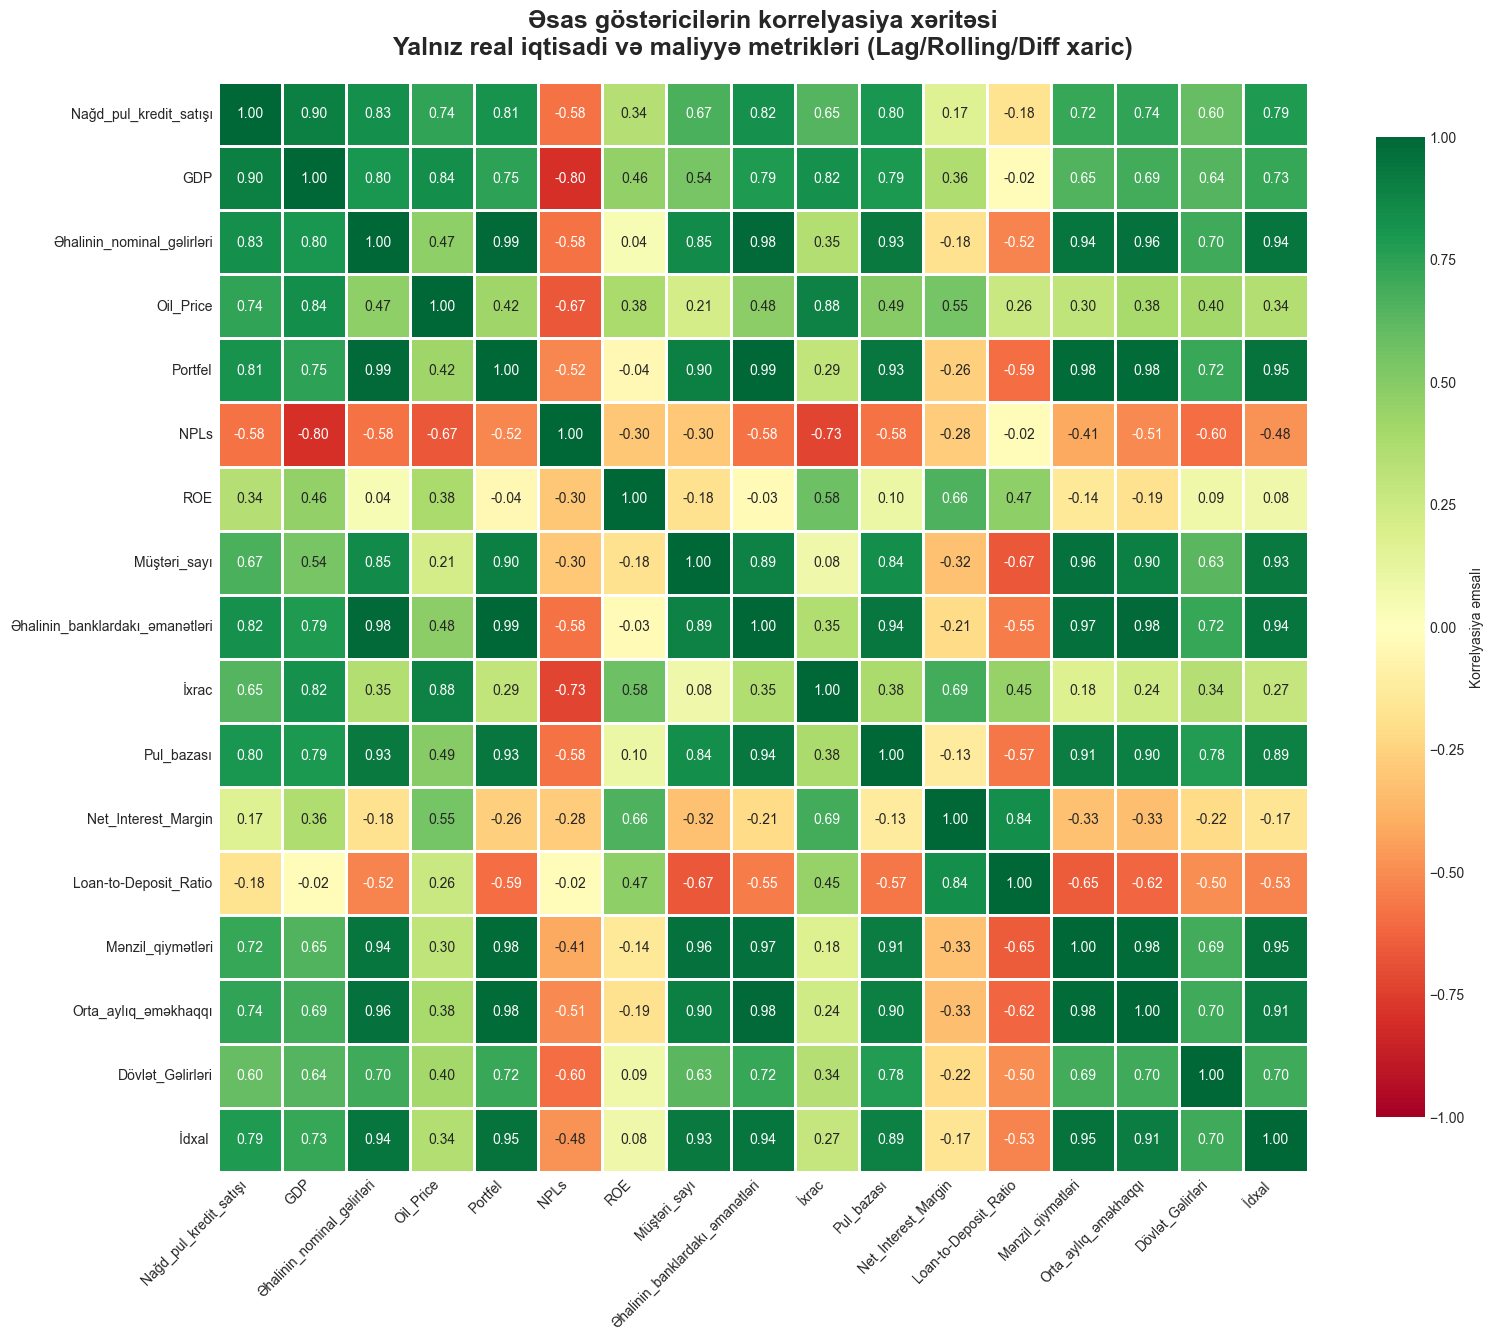

In [37]:
# Chart 10: Korrelyasiya Xəritəsi (Heatmap)
# Select key financial and economic indicators (EXCLUDE engineered features)

# Define excluded columns
exclude_cols = [
    'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4',
    'Rolling_Mean_2', 'Rolling_Mean_3', 'Rolling_Mean_4',
    'Rolling_Std_2', 'Rolling_Std_3', 'Rolling_Std_4',
    'Diff_1', 'Diff_4',
    'Time_Index', 'Quarter_Sin', 'Quarter_Cos',  # Time encoding features
    'Year', 'Quarter',  # Already captured by Time_Index
    'Kumulyativ_satish',  # Cumulative of target
]

# Select key metrics
key_metrics = [
    'Nağd_pul_kredit_satışı', 'GDP', 'Əhalinin_nominal_gəlirləri',
    'Oil_Price', 'Portfel', 'NPLs', 'ROE', 'Müştəri_sayı',
    'Əhalinin_banklardakı_əmanətləri', 'İxrac', 'Pul_bazası',
    'Net_Interest_Margin', 'Loan-to-Deposit_Ratio', 'Mənzil_qiymətləri',
    'Orta_aylıq_əməkhaqqı', 'Dövlət_Gəlirləri', 'İdxal '
]

# Filter only existing columns and not in exclude list
existing_metrics = [col for col in key_metrics if col in df.columns and col not in exclude_cols]
correlation_matrix = df[existing_metrics].corr()

fig, ax = plt.subplots(figsize=(16, 14))

# Create heatmap with annotations
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f',
            cmap='RdYlGn',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8, "label": "Korrelyasiya əmsalı"},
            vmin=-1, vmax=1,
            ax=ax)

ax.set_title('Əsas göstəricilərin korrelyasiya xəritəsi\nYalnız real iqtisadi və maliyyə metrikləri (Lag/Rolling/Diff xaric)', 
            fontsize=18, fontweight='bold', pad=20)

# Rotate labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('images/professional_10_correlation_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

# Print top 3 correlations with credit sales (excluding self)
sales_corr = correlation_matrix['Nağd_pul_kredit_satışı'].drop('Nağd_pul_kredit_satışı').sort_values(ascending=False)


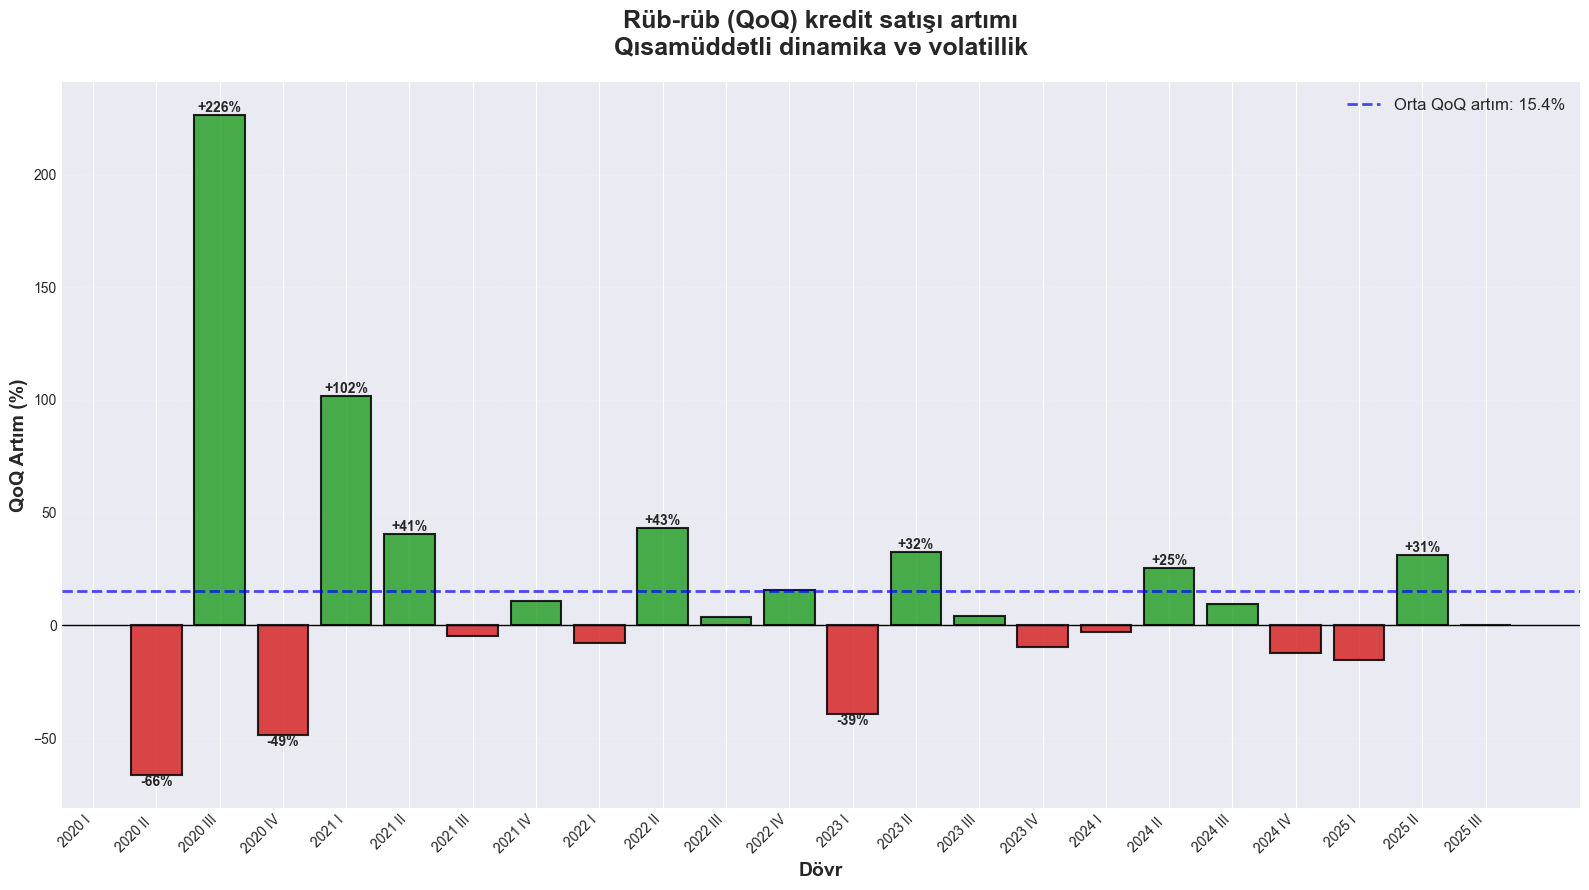

In [38]:
# Chart 11: Rüb-rüb (QoQ) Artım
df['QoQ_Growth'] = df['Nağd_pul_kredit_satışı'].pct_change() * 100

fig, ax = plt.subplots(figsize=(16, 9))

# Bar chart with positive/negative colors
colors = ['#2ca02c' if x > 0 else '#d62728' for x in df['QoQ_Growth']]
bars = ax.bar(range(len(df)), df['QoQ_Growth'], 
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

# Zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Grid and formatting
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.5)
ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('QoQ Artım (%)', fontsize=14, fontweight='bold')
ax.set_title('Rüb-rüb (QoQ) kredit satışı artımı\nQısamüddətli dinamika və volatillik', 
            fontsize=18, fontweight='bold', pad=20)

# X axis labels
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Value labels for significant changes
for i, (bar, val) in enumerate(zip(bars, df['QoQ_Growth'])):
    if abs(val) > 25 and not pd.isna(val):  # Only label large changes
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.0f}%',
                ha='center', va='bottom' if val > 0 else 'top', 
                fontsize=10, fontweight='bold')

# Average QoQ growth line
avg_qoq = df['QoQ_Growth'].mean()
ax.axhline(y=avg_qoq, color='blue', linestyle='--', linewidth=2, 
          label=f'Orta QoQ artım: {avg_qoq:.1f}%', alpha=0.7)

ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig('images/professional_11_qoq_growth.png', dpi=200, bbox_inches='tight')
plt.show()

# Find min and max QoQ
qoq_valid = df['QoQ_Growth'].dropna()


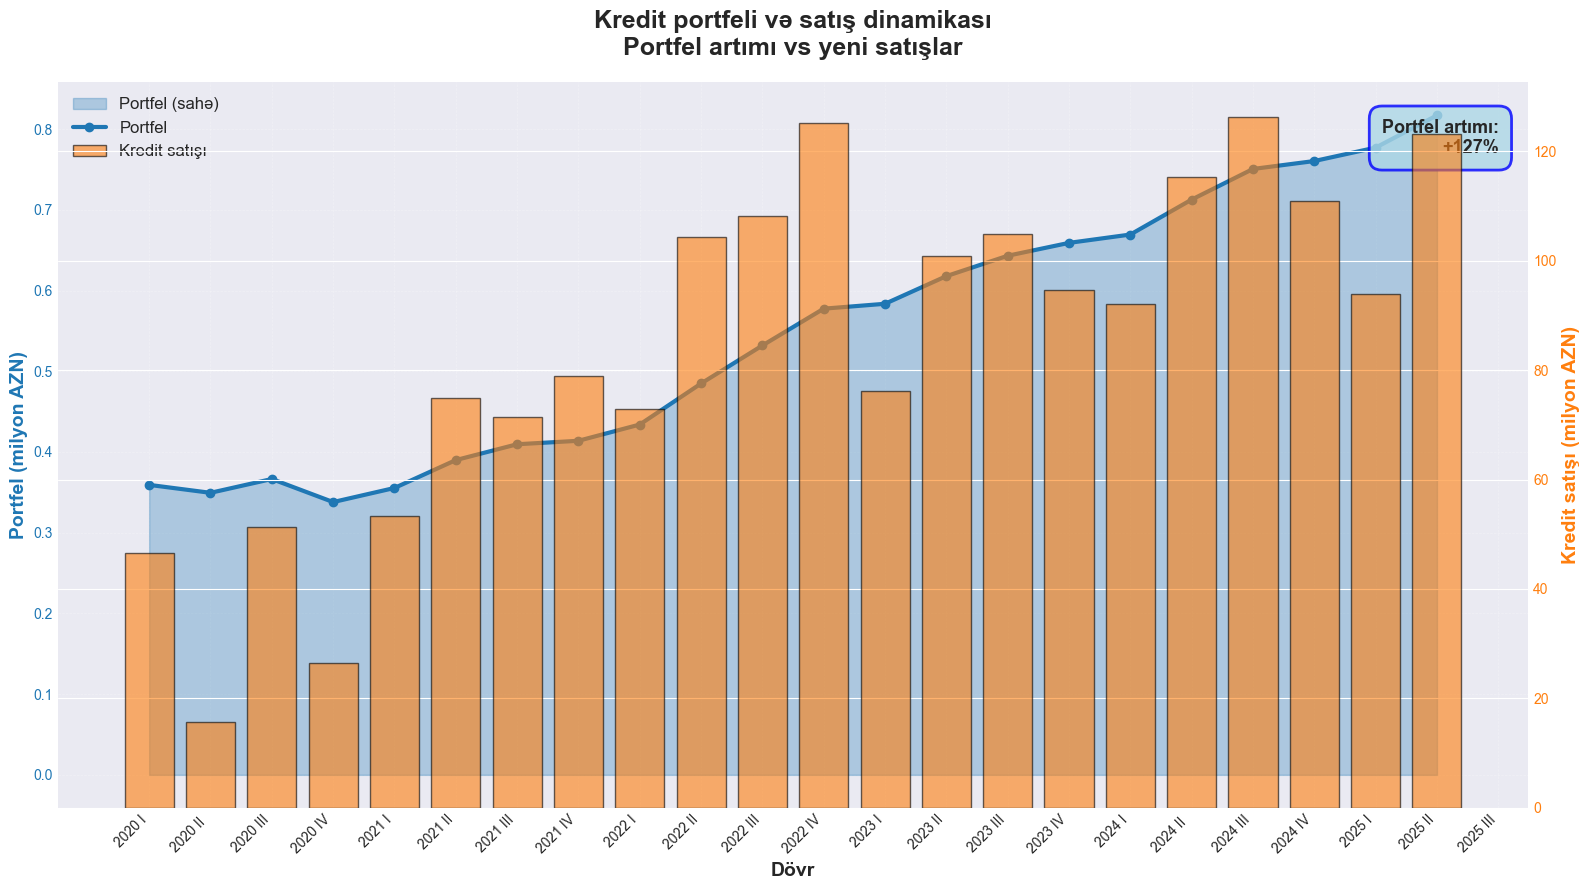

In [39]:
# Chart 12: Portfel və Kredit Satışı Əlaqəsi
fig, ax1 = plt.subplots(figsize=(16, 9))

# Portfel (area chart)
color1 = '#1f77b4'
ax1.fill_between(range(len(df)), df['Portfel']/1e6, 
                 alpha=0.3, color=color1, label='Portfel (sahə)')
ax1.plot(range(len(df)), df['Portfel']/1e6,
        linewidth=3, marker='o', markersize=6, 
        color=color1, label='Portfel', zorder=3)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfel (milyon AZN)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Kredit satışı (second axis)
ax2 = ax1.twinx()
color2 = '#ff7f0e'
ax2.bar(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
       alpha=0.6, color=color2, edgecolor='black', linewidth=1,
       label='Kredit satışı')

ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title
ax1.set_title('Kredit portfeli və satış dinamikası\nPortfel artımı vs yeni satışlar', 
             fontsize=18, fontweight='bold', pad=20)

# X axis
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Growth annotation
df_port_valid = df[df['Portfel'].notna()]
port_growth = ((df_port_valid['Portfel'].iloc[-1] / df_port_valid['Portfel'].iloc[0]) - 1) * 100
ax1.text(0.98, 0.95, f'Portfel artımı:\n+{port_growth:.0f}%',
        transform=ax1.transAxes, fontsize=13, fontweight='bold',
        ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightblue', 
                 edgecolor='blue', alpha=0.8, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_12_portfolio_sales.png', dpi=200, bbox_inches='tight')
plt.show()



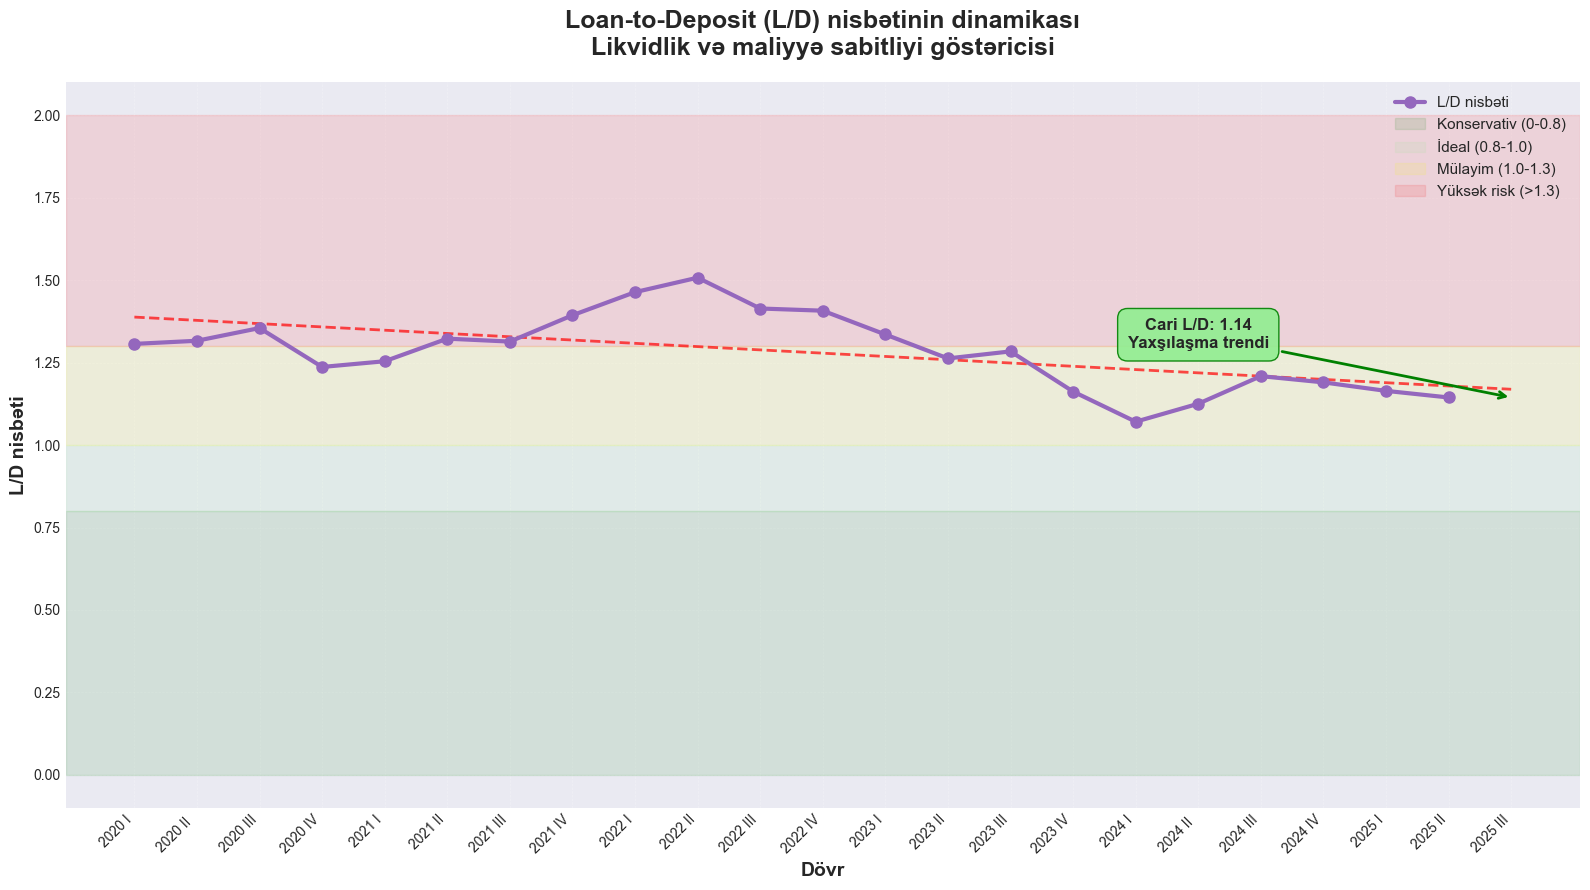

In [40]:
# Chart 13: Loan-to-Deposit (L/D) Nisbəti
fig, ax = plt.subplots(figsize=(16, 9))

# L/D ratio line
ax.plot(range(len(df)), df['Loan-to-Deposit_Ratio'], 
        linewidth=3, marker='o', markersize=8, 
        color='#9467bd', label='L/D nisbəti', zorder=3)

ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('L/D nisbəti', fontsize=14, fontweight='bold')
ax.set_title('Loan-to-Deposit (L/D) nisbətinin dinamikası\nLikvidlik və maliyyə sabitliyi göstəricisi', 
            fontsize=18, fontweight='bold', pad=20)

# Benchmark zones
ax.axhspan(0, 0.8, alpha=0.1, color='green', label='Konservativ (0-0.8)')
ax.axhspan(0.8, 1.0, alpha=0.1, color='lightgreen', label='İdeal (0.8-1.0)')
ax.axhspan(1.0, 1.3, alpha=0.1, color='yellow', label='Mülayim (1.0-1.3)')
ax.axhspan(1.3, 2.0, alpha=0.1, color='red', label='Yüksək risk (>1.3)')

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['Rüblər'], rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)

# Trend line
df_ld_valid = df[df['Loan-to-Deposit_Ratio'].notna()]
z = np.polyfit(range(len(df_ld_valid)), df_ld_valid['Loan-to-Deposit_Ratio'], 1)
p = np.poly1d(z)
ax.plot(range(len(df)), p(range(len(df))), 
        "--", linewidth=2, color='red', 
        label='Trend (azalan)', alpha=0.7, zorder=2)

# Current value annotation
current_ld = df_ld_valid['Loan-to-Deposit_Ratio'].iloc[-1]
ax.annotate(f'Cari L/D: {current_ld:.2f}\nYaxşılaşma trendi', 
            xy=(len(df)-1, current_ld),
            xytext=(len(df)-6, current_ld+0.15),
            fontsize=12, fontweight='bold', ha='center',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='lightgreen', 
                     edgecolor='green', alpha=0.9),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.tight_layout()
plt.savefig('images/professional_13_ld_ratio.png', dpi=200, bbox_inches='tight')
plt.show()

ld_change = ((current_ld / df_ld_valid['Loan-to-Deposit_Ratio'].iloc[0]) - 1) * 100


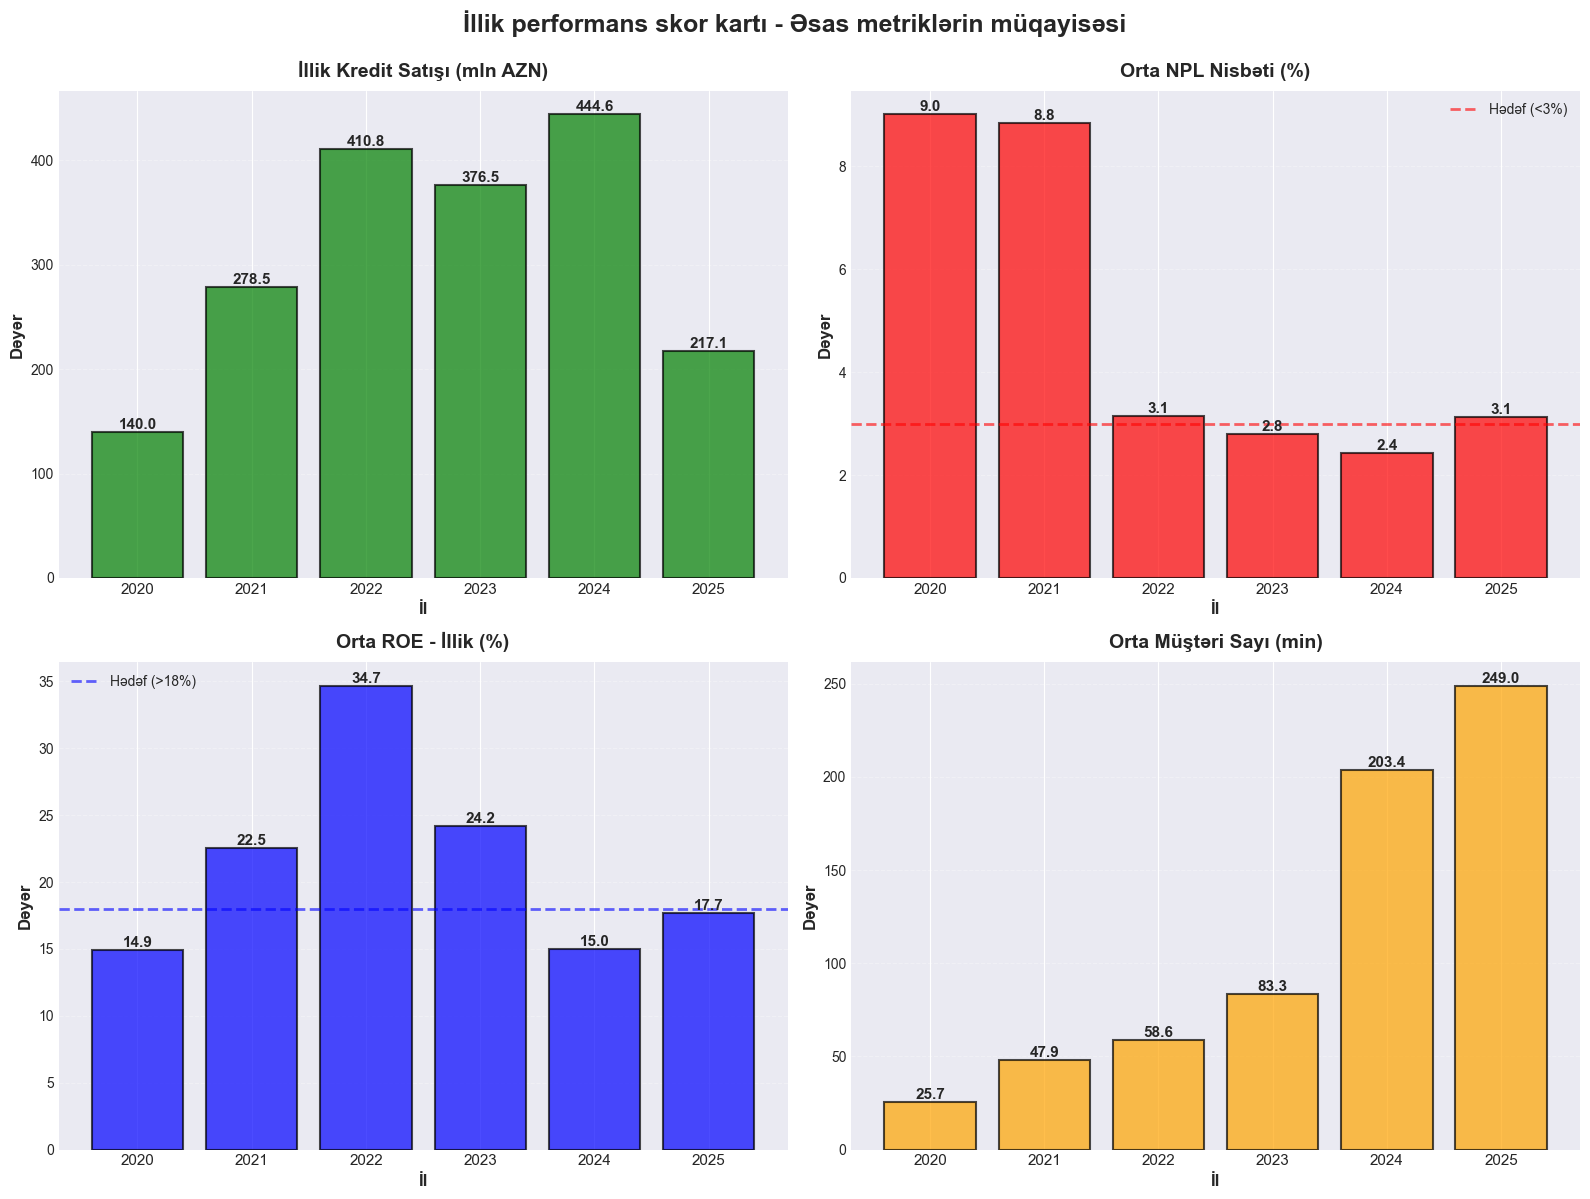

In [41]:
# Chart 14: İllik Performans Skor Kartı
# First, annualize ROE for each quarter
df_temp = df.copy()
df_temp['ROE_annualized'] = df_temp['ROE'].copy()

for idx_row in df_temp.index:
    quarter = df_temp.loc[idx_row, 'Quarter']
    roe = df_temp.loc[idx_row, 'ROE']
    if pd.notna(roe) and pd.notna(quarter):
        if quarter == 1:
            df_temp.loc[idx_row, 'ROE_annualized'] = roe * 4
        elif quarter == 2:
            df_temp.loc[idx_row, 'ROE_annualized'] = roe * 2
        elif quarter == 3:
            df_temp.loc[idx_row, 'ROE_annualized'] = roe * (4/3)

# Aggregate by year - SUM for sales, MEAN for percentages
yearly_metrics = df_temp.groupby('Year').agg({
    'Nağd_pul_kredit_satışı': 'sum',  # Total yearly sales
    'NPL_percentage': 'mean',  # Average NPL percentage
    'ROE_annualized': 'mean',  # Average annualized ROE
    'Müştəri_sayı': 'mean'  # Average customer count
})

yearly_metrics_normalized = yearly_metrics.copy()
# Normalize metrics to 0-100 scale
for col in yearly_metrics.columns:
    if col == 'NPL_percentage':  # Lower is better for NPL
        yearly_metrics_normalized[col] = 100 - (yearly_metrics[col] / yearly_metrics[col].max() * 100)
    else:  # Higher is better for others
        yearly_metrics_normalized[col] = (yearly_metrics[col] / yearly_metrics[col].max() * 100)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('İllik performans skor kartı - Əsas metriklərin müqayisəsi', 
            fontsize=18, fontweight='bold', y=0.995)

metrics_display = {
    'Nağd_pul_kredit_satışı': ('İllik Kredit Satışı (mln AZN)', 'green'),
    'NPL_percentage': ('Orta NPL Nisbəti (%)', 'red'),
    'ROE_annualized': ('Orta ROE - İllik (%)', 'blue'),
    'Müştəri_sayı': ('Orta Müştəri Sayı (min)', 'orange')
}

for idx_m, (metric, (title, color)) in enumerate(metrics_display.items()):
    ax = axes[idx_m // 2, idx_m % 2]
    
    # Original values
    if metric == 'Nağd_pul_kredit_satışı':
        values = yearly_metrics[metric] / 1e6
    elif metric == 'Müştəri_sayı':
        values = yearly_metrics[metric] / 1000
    elif metric == 'NPL_percentage':
        values = yearly_metrics[metric]  # Already percentage
    elif metric == 'ROE_annualized':
        values = yearly_metrics[metric] * 100  # Convert to percentage
    else:
        values = yearly_metrics[metric]
    
    bars = ax.bar(range(len(values)), values, 
                  color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add normalized score (0-100) at top
    norm_values = yearly_metrics_normalized[metric]
    # for i, (bar, norm_val) in enumerate(zip(bars, norm_values)):
    #     ax.text(bar.get_x() + bar.get_width()/2., 
    #            ax.get_ylim()[1] * 0.95,
    #            f'Skor: {norm_val:.0f}',
    #            ha='center', va='top', fontsize=9, 
    #            style='italic', color='darkblue')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('İl', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dəyər', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels([int(year) for year in yearly_metrics.index], fontsize=11)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add reference line for NPL
    if metric == 'NPL_percentage':
        ax.axhline(y=3, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Hədəf (<3%)')
        ax.legend(loc='upper right', fontsize=10)
    
    # Add reference line for ROE
    if metric == 'ROE_annualized':
        ax.axhline(y=18, color='blue', linestyle='--', linewidth=2, alpha=0.6, label='Hədəf (>18%)')
        ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('images/professional_14_scorecard.png', dpi=200, bbox_inches='tight')
plt.show()

# Print summary


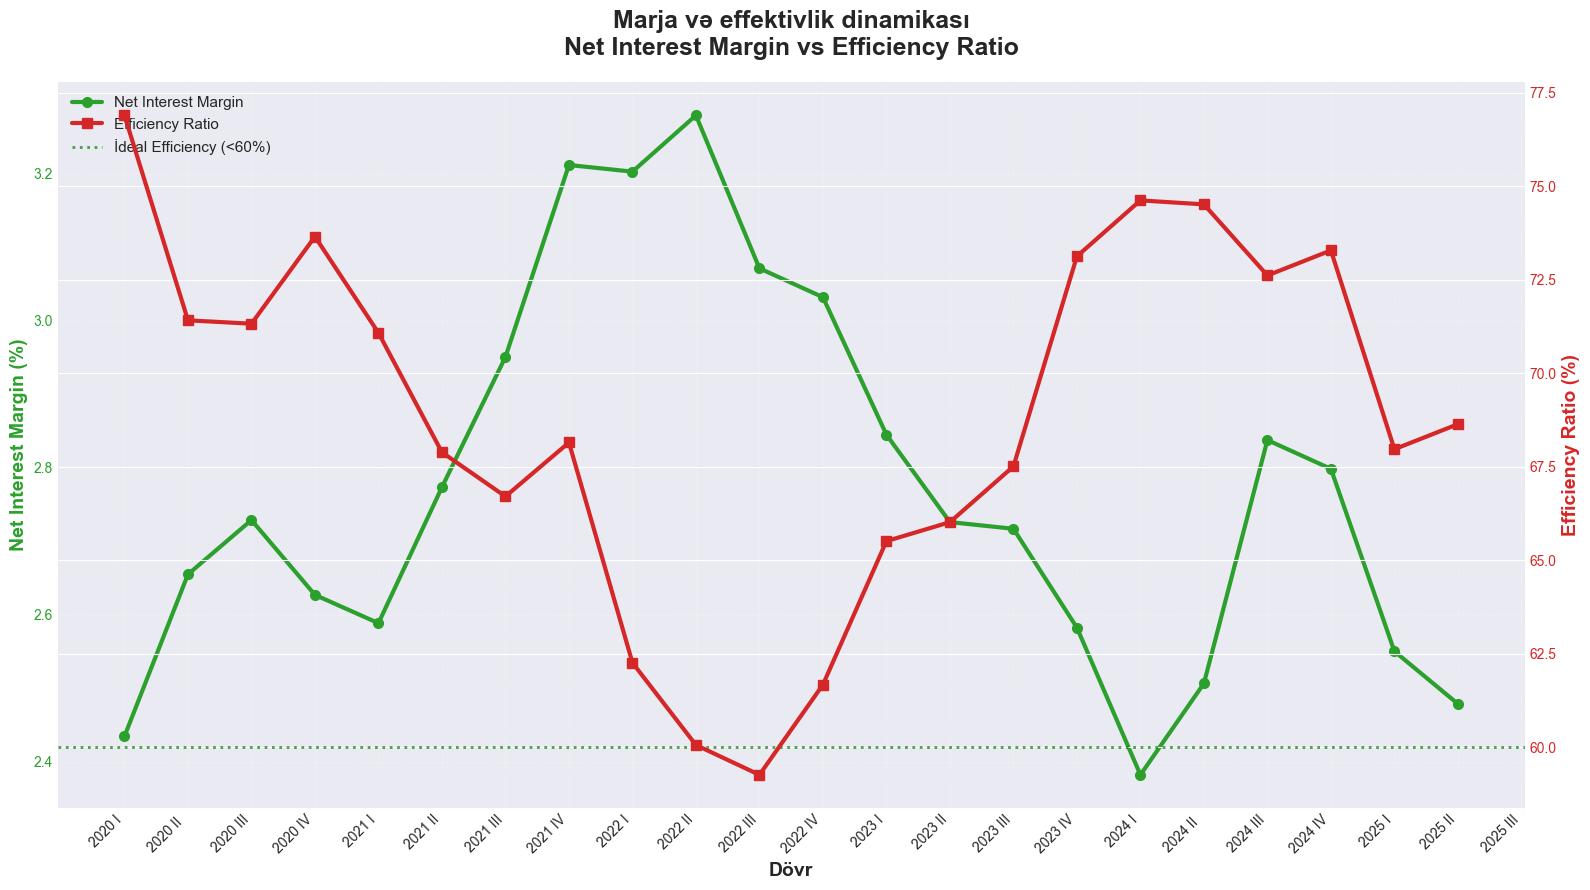

In [42]:
# Chart 15: Net Interest Margin və Efficiency Ratio
fig, ax1 = plt.subplots(figsize=(16, 9))

# Net Interest Margin (left axis)
color1 = '#2ca02c'
ax1.plot(range(len(df)), df['Net_Interest_Margin']*100, 
        linewidth=3, marker='o', markersize=7, 
        color=color1, label='Net Interest Margin', zorder=3)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Net Interest Margin (%)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Efficiency Ratio (right axis)
ax2 = ax1.twinx()
color2 = '#d62728'
ax2.plot(range(len(df)), df['Efficiency_Ratio']*100,
        linewidth=3, marker='s', markersize=7, 
        color=color2, label='Efficiency Ratio', zorder=3)

ax2.set_ylabel('Efficiency Ratio (%)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Add benchmark line for Efficiency Ratio
ax2.axhline(y=60, color='green', linestyle=':', linewidth=2, 
           label='İdeal Efficiency (<60%)', alpha=0.7)

# Title
ax1.set_title('Marja və effektivlik dinamikası\nNet Interest Margin vs Efficiency Ratio', 
             fontsize=18, fontweight='bold', pad=20)

# X axis
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95)

# Current values annotation
df_nim_valid = df[df['Net_Interest_Margin'].notna()]
df_eff_valid = df[df['Efficiency_Ratio'].notna()]
current_nim = df_nim_valid['Net_Interest_Margin'].iloc[-1] * 100
current_eff = df_eff_valid['Efficiency_Ratio'].iloc[-1] * 100

# ax1.text(0.02, 0.98, 
#         f'Cari göstəricilər:\n'
#         f'NIM: {current_nim:.2f}%\n'
#         f'Efficiency: {current_eff:.1f}%',
#         transform=ax1.transAxes, fontsize=12, fontweight='bold',
#         ha='left', va='top',
#         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightyellow', 
#                  edgecolor='orange', alpha=0.9, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_15_margin_efficiency.png', dpi=200, bbox_inches='tight')
plt.show()

nim_change = ((current_nim / (df_nim_valid['Net_Interest_Margin'].iloc[0]*100)) - 1) * 100


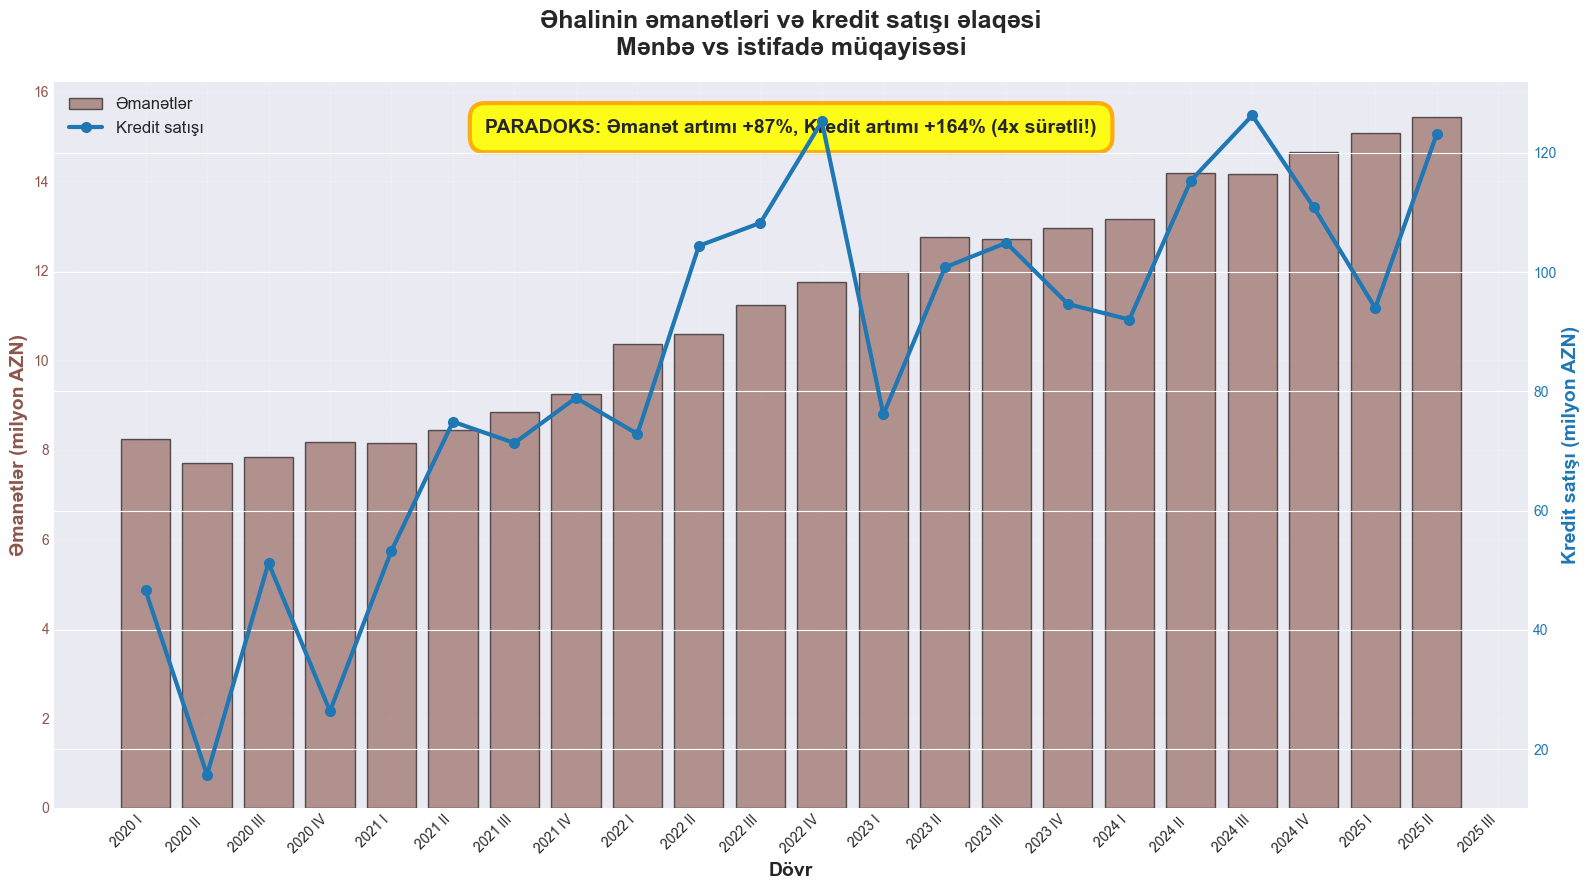

In [43]:
# Chart 16: Əmanət-Kredit Əlaqəsi
fig, ax1 = plt.subplots(figsize=(16, 9))

# Əmanətlər (bar chart)
color1 = '#8c564b'
ax1.bar(range(len(df)), df['Əhalinin_banklardakı_əmanətləri']/1e6,
       alpha=0.6, color=color1, edgecolor='black', linewidth=1,
       label='Əmanətlər', zorder=2)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Əmanətlər (milyon AZN)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Kredit satışı (ikinci ox)
ax2 = ax1.twinx()
color2 = '#1f77b4'
ax2.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=3, marker='o', markersize=7, 
        color=color2, label='Kredit satışı', zorder=3)
        
ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Başlıq
ax1.set_title('Əhalinin əmanətləri və kredit satışı əlaqəsi\nMənbə vs istifadə müqayisəsi', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Artım müqayisəsi
df_deposit_valid = df[df['Əhalinin_banklardakı_əmanətləri'].notna()]
df_credit_valid = df[df['Nağd_pul_kredit_satışı'].notna()]
deposit_growth = ((df_deposit_valid['Əhalinin_banklardakı_əmanətləri'].iloc[-1] / df_deposit_valid['Əhalinin_banklardakı_əmanətləri'].iloc[0]) - 1) * 100
credit_growth = ((df_credit_valid['Nağd_pul_kredit_satışı'].iloc[-1] / df_credit_valid['Nağd_pul_kredit_satışı'].iloc[0]) - 1) * 100

ax1.text(0.5, 0.95, 
        f'PARADOKS: Əmanət artımı +{deposit_growth:.0f}%, Kredit artımı +{credit_growth:.0f}% (4x sürətli!)',
        transform=ax1.transAxes, fontsize=14, fontweight='bold',
        ha='center', va='top',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', edgecolor='orange', 
                 alpha=0.9, linewidth=3))

plt.tight_layout()
plt.savefig('images/professional_16_deposits_credits.png', dpi=200, bbox_inches='tight')
plt.show()



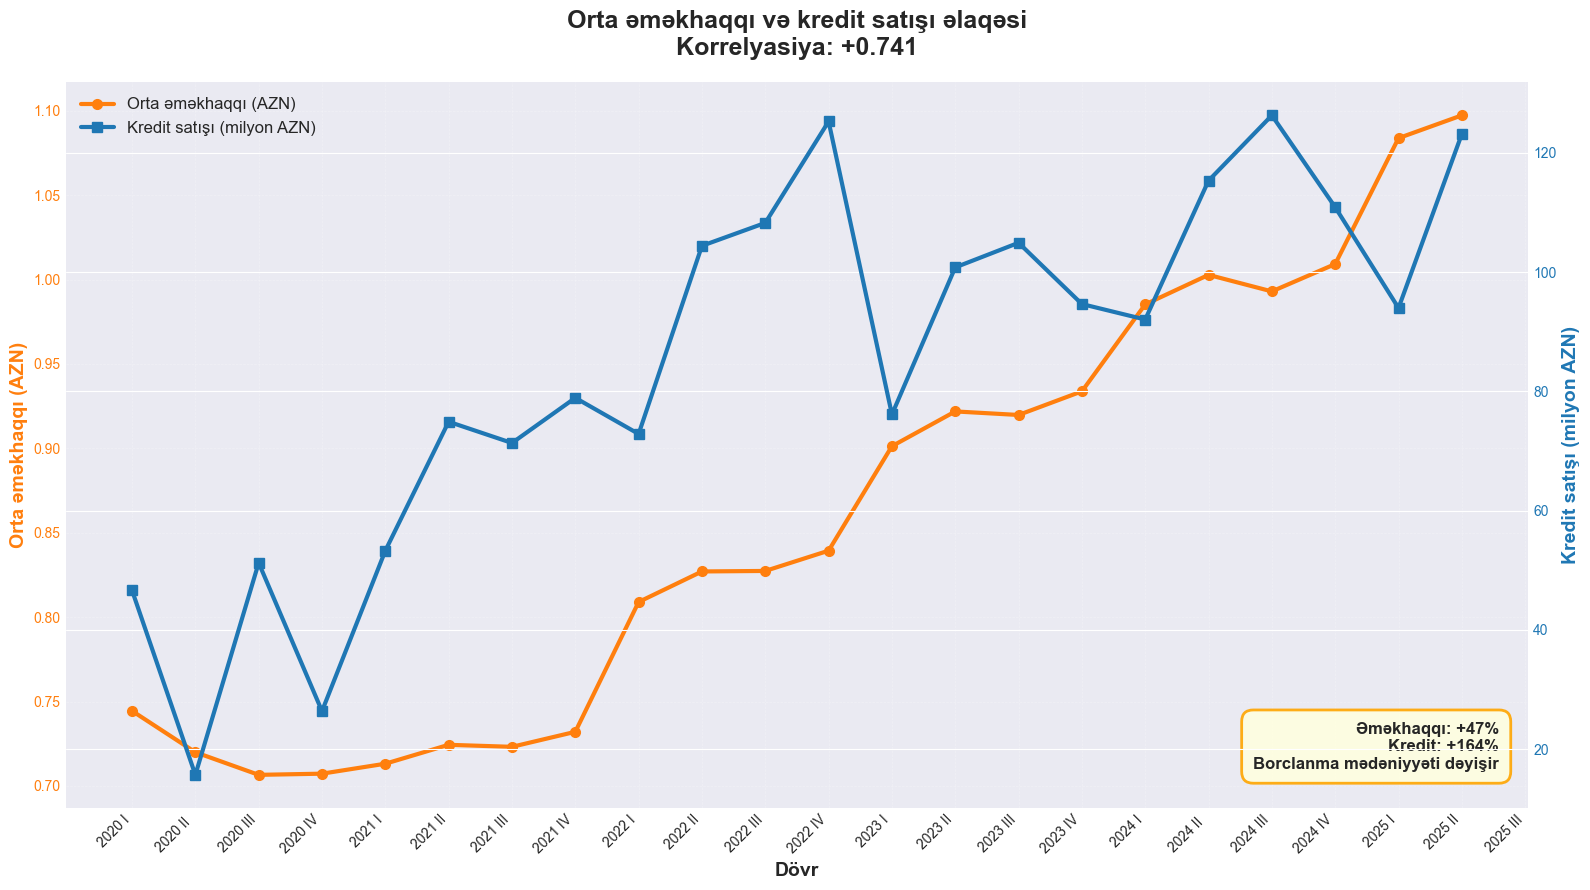

In [44]:
# Chart 17: Əməkhaqqı və Kredit Satışı
fig, ax1 = plt.subplots(figsize=(16, 9))

# Əməkhaqqı
color1 = '#ff7f0e'
ax1.plot(range(len(df)), df['Orta_aylıq_əməkhaqqı'], 
        linewidth=3, marker='o', markersize=7, 
        color=color1, label='Orta əməkhaqqı (AZN)', zorder=3)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Orta əməkhaqqı (AZN)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Kredit satışı (ikinci ox)
ax2 = ax1.twinx()
color2 = '#1f77b4'
ax2.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=3, marker='s', markersize=7, 
        color=color2, label='Kredit satışı (milyon AZN)', zorder=3)
ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Başlıq
wage_credit_corr = df['Orta_aylıq_əməkhaqqı'].corr(df['Nağd_pul_kredit_satışı'])
ax1.set_title(f'Orta əməkhaqqı və kredit satışı əlaqəsi\nKorrelyasiya: {wage_credit_corr:+.3f}', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Artım müqayisəsi
df_wage_valid = df[df['Orta_aylıq_əməkhaqqı'].notna()]
wage_growth = ((df_wage_valid['Orta_aylıq_əməkhaqqı'].iloc[-1] / df_wage_valid['Orta_aylıq_əməkhaqqı'].iloc[0]) - 1) * 100
df_credit_valid = df[df['Nağd_pul_kredit_satışı'].notna()]
credit_growth = ((df_credit_valid['Nağd_pul_kredit_satışı'].iloc[-1] / df_credit_valid['Nağd_pul_kredit_satışı'].iloc[0]) - 1) * 100

ax1.text(0.98, 0.05, 
        f'Əməkhaqqı: +{wage_growth:.0f}%\nKredit: +{credit_growth:.0f}%\nBorclanma mədəniyyəti dəyişir',
        transform=ax1.transAxes, fontsize=12, fontweight='bold',
        ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightyellow', 
                 edgecolor='orange', alpha=0.9, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_17_wage_credit.png', dpi=200, bbox_inches='tight')
plt.show()



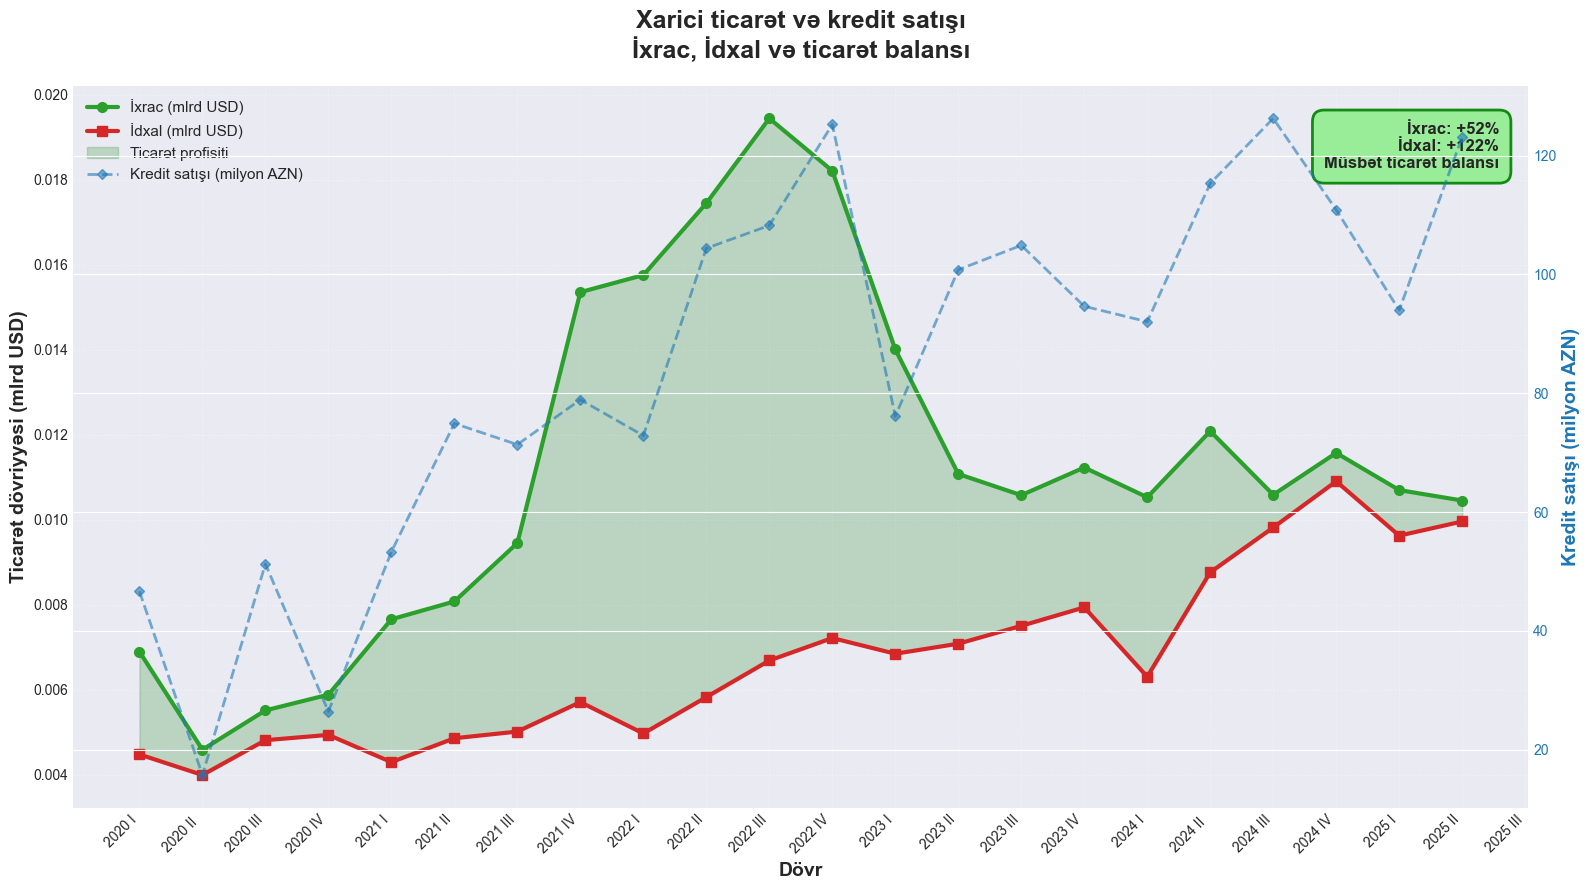

In [45]:
# Chart 18: Xarici Ticarət (İxrac vs İdxal)
fig, ax1 = plt.subplots(figsize=(16, 9))

# İxrac
color1 = '#2ca02c'
ax1.plot(range(len(df)), df['İxrac']/1e9, 
        linewidth=3, marker='o', markersize=7, 
        color=color1, label='İxrac (mlrd USD)', zorder=3)

# İdxal  
color2 = '#d62728'
ax1.plot(range(len(df)), df['İdxal ']/1e9,  # Note: column has space
        linewidth=3, marker='s', markersize=7, 
        color=color2, label='İdxal (mlrd USD)', zorder=3)

# Ticarət balansı (area fill)
trade_balance = df['İxrac'] - df['İdxal ']
ax1.fill_between(range(len(df)), df['İdxal ']/1e9, df['İxrac']/1e9,
                where=(df['İxrac'] > df['İdxal ']),
                alpha=0.2, color='green', label='Ticarət profisiti')

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ticarət dövriyyəsi (mlrd USD)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Kredit satışı (ikinci ox)
ax2 = ax1.twinx()
color3 = '#1f77b4'
ax2.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=2, marker='D', markersize=5, 
        color=color3, alpha=0.6, linestyle='--',
        label='Kredit satışı (milyon AZN)', zorder=2)
ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

# Başlıq
ax1.set_title('Xarici ticarət və kredit satışı\nİxrac, İdxal və ticarət balansı', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95)

# Artım statistikası
df_export_valid = df[df['İxrac'].notna()]
df_import_valid = df[df['İdxal '].notna()]
export_growth = ((df_export_valid['İxrac'].iloc[-1] / df_export_valid['İxrac'].iloc[0]) - 1) * 100
import_growth = ((df_import_valid['İdxal '].iloc[-1] / df_import_valid['İdxal '].iloc[0]) - 1) * 100

ax1.text(0.98, 0.95, 
        f'İxrac: +{export_growth:.0f}%\nİdxal: +{import_growth:.0f}%\nMüsbət ticarət balansı',
        transform=ax1.transAxes, fontsize=12, fontweight='bold',
        ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightgreen', 
                 edgecolor='green', alpha=0.9, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_18_trade_balance.png', dpi=200, bbox_inches='tight')
plt.show()



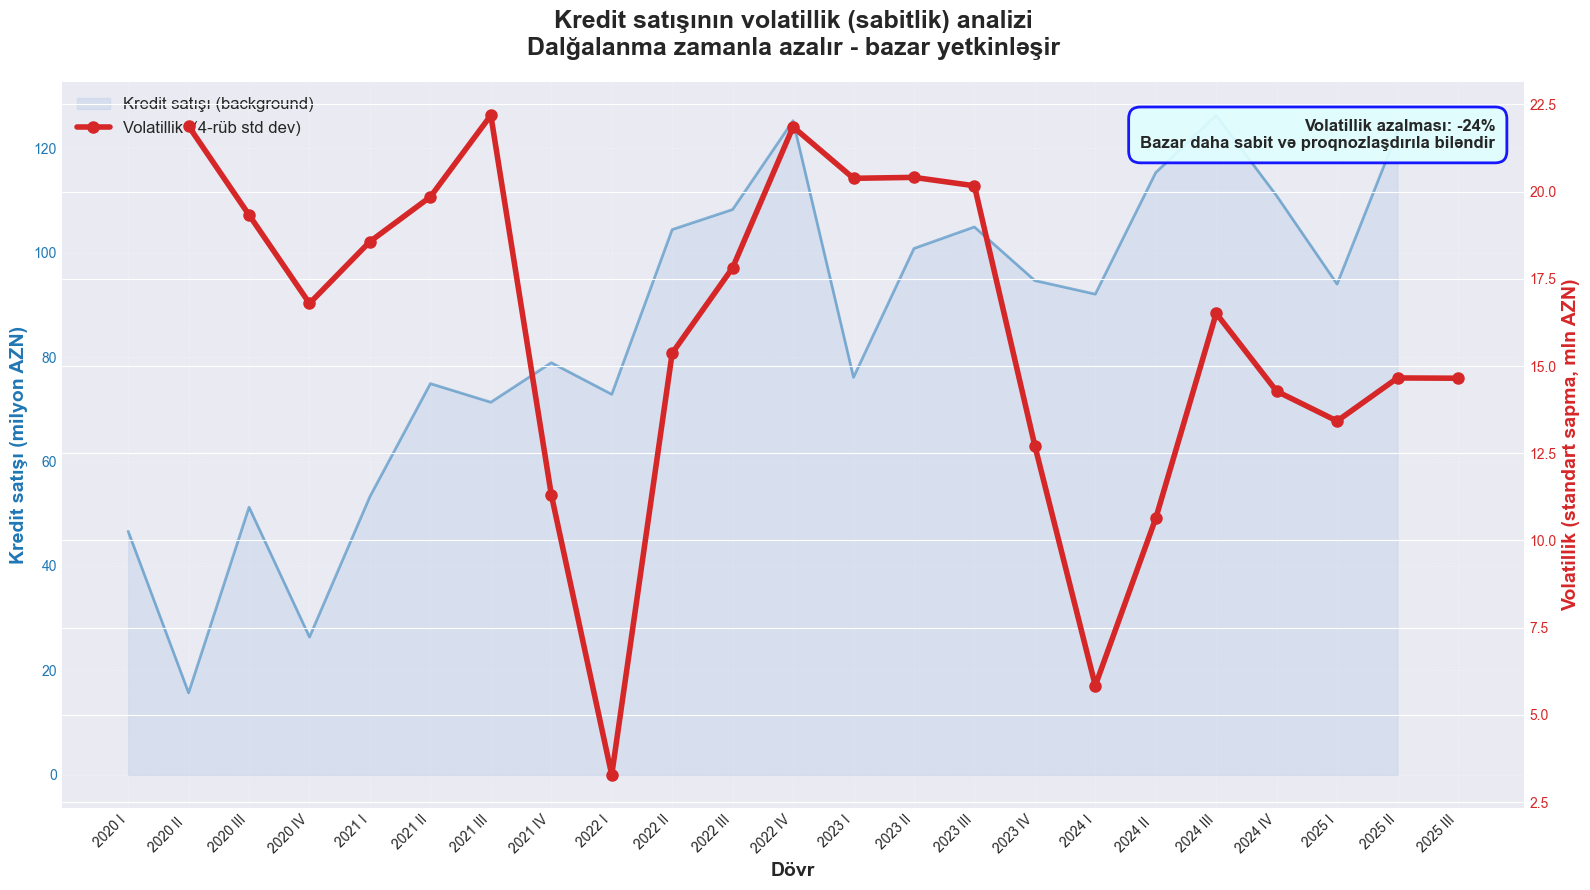

In [46]:
# Chart 19: Kredit Satışının Volatillik Analizi
# Calculate rolling standard deviation (4-quarter window)
df['Rolling_Std'] = df['Nağd_pul_kredit_satışı'].rolling(window=4, min_periods=2).std() / 1e6

fig, ax1 = plt.subplots(figsize=(16, 9))

# Kredit satışı (background)
color1 = '#aec7e8'
ax1.fill_between(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
                alpha=0.3, color=color1, label='Kredit satışı (background)')
ax1.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=2, color='#1f77b4', alpha=0.5, zorder=2)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Volatillik (ikinci ox)
ax2 = ax1.twinx()
color2 = '#d62728'
ax2.plot(range(len(df)), df['Rolling_Std'],
        linewidth=4, marker='o', markersize=8, 
        color=color2, label='Volatillik  (4-rüb std dev)', zorder=3)
        
ax2.set_ylabel('Volatillik (standart sapma, mln AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Başlıq
ax1.set_title('Kredit satışının volatillik (sabitlik) analizi\nDalğalanma zamanla azalır - bazar yetkinləşir', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Volatillik trendi
df_vol_valid = df[df['Rolling_Std'].notna()]
if len(df_vol_valid) > 5:
    early_vol = df_vol_valid['Rolling_Std'].iloc[:5].mean()
    recent_vol = df_vol_valid['Rolling_Std'].iloc[-5:].mean()
    vol_change = ((recent_vol / early_vol) - 1) * 100
    
    ax2.text(0.98, 0.95, 
            f'Volatillik azalması: {vol_change:.0f}%\nBazar daha sabit və proqnozlaşdırıla biləndir',
            transform=ax1.transAxes, fontsize=12, fontweight='bold',
            ha='right', va='top',
            bbox=dict(boxstyle='round,pad=0.7', facecolor='lightcyan', 
                     edgecolor='blue', alpha=0.9, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_19_volatility.png', dpi=200, bbox_inches='tight')
plt.show()



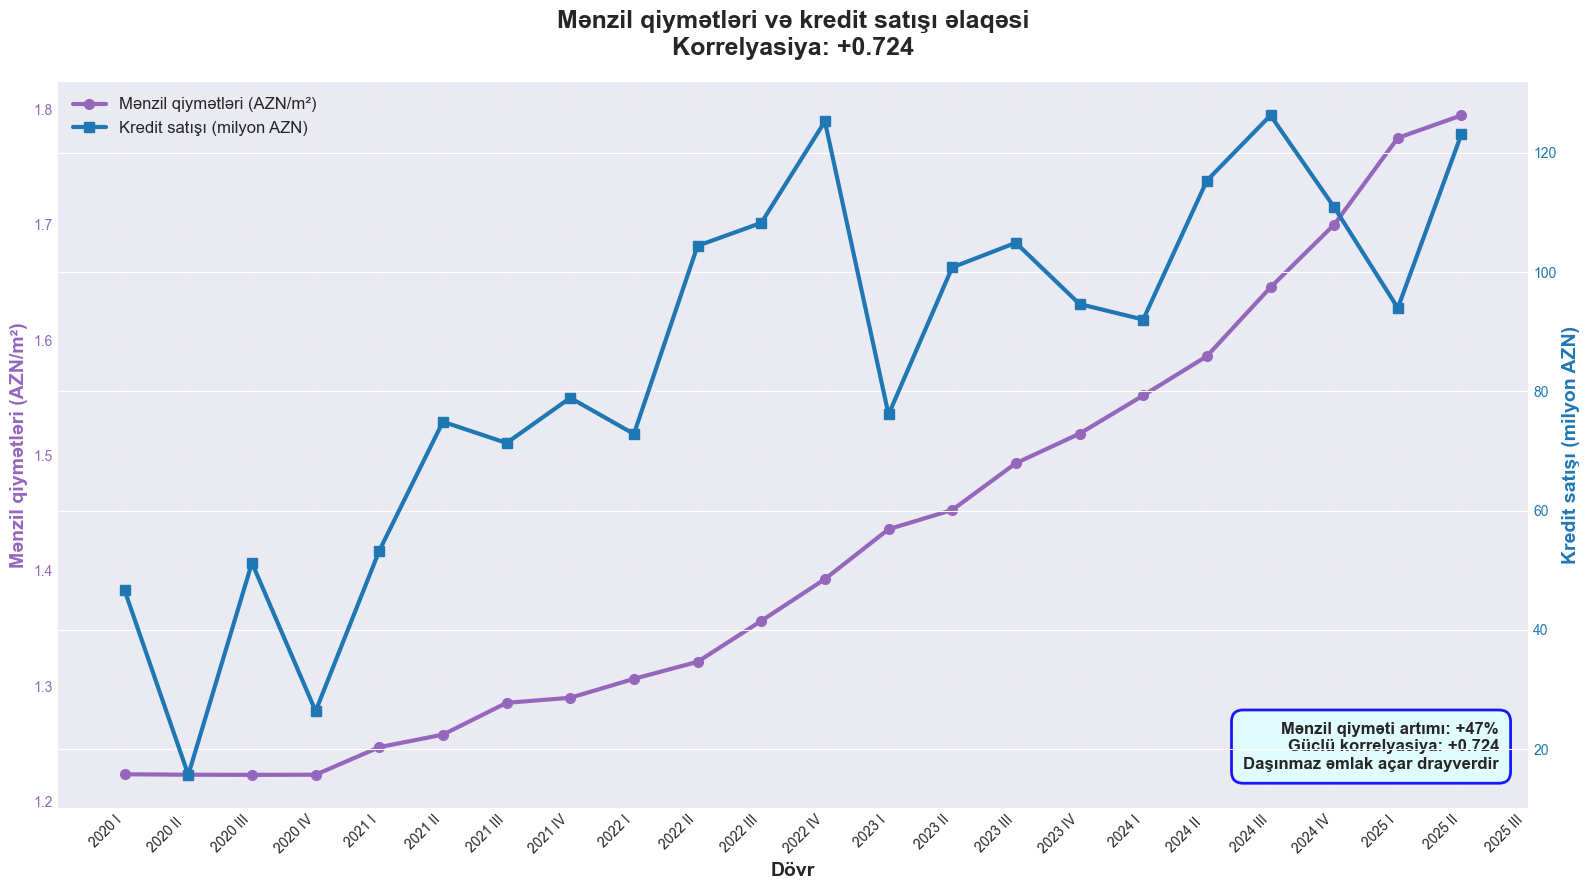

In [47]:
# Chart 20: Mənzil Qiymətləri və Kredit Satışı
fig, ax1 = plt.subplots(figsize=(16, 9))

# Mənzil qiymətləri
color1 = '#9467bd'
ax1.plot(range(len(df)), df['Mənzil_qiymətləri'], 
        linewidth=3, marker='o', markersize=7, 
        color=color1, label='Mənzil qiymətləri (AZN/m²)', zorder=3)

ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Mənzil qiymətləri (AZN/m²)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, zorder=1)

# Kredit satışı (ikinci ox)
ax2 = ax1.twinx()
color2 = '#1f77b4'
ax2.plot(range(len(df)), df['Nağd_pul_kredit_satışı']/1e6,
        linewidth=3, marker='s', markersize=7, 
        color=color2, label='Kredit satışı (milyon AZN)', zorder=3)
ax2.set_ylabel('Kredit satışı (milyon AZN)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Başlıq
housing_corr = df['Mənzil_qiymətləri'].corr(df['Nağd_pul_kredit_satışı'])
ax1.set_title(f'Mənzil qiymətləri və kredit satışı əlaqəsi\nKorrelyasiya: {housing_corr:+.3f}', 
             fontsize=18, fontweight='bold', pad=20)

# X oxu
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Rüblər'], rotation=45, ha='right')

# Birləşdirilmiş legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.95)

# Artım müqayisəsi
df_house_valid = df[df['Mənzil_qiymətləri'].notna()]
house_growth = ((df_house_valid['Mənzil_qiymətləri'].iloc[-1] / df_house_valid['Mənzil_qiymətləri'].iloc[0]) - 1) * 100

ax1.text(0.98, 0.05, 
        f'Mənzil qiyməti artımı: +{house_growth:.0f}%\nGüclü korrelyasiya: {housing_corr:+.3f}\nDaşınmaz əmlak açar drayverdir',
        transform=ax1.transAxes, fontsize=12, fontweight='bold',
        ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='lightcyan', 
                 edgecolor='blue', alpha=0.9, linewidth=2))

plt.tight_layout()
plt.savefig('images/professional_20_housing_credit.png', dpi=200, bbox_inches='tight')
plt.show()



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


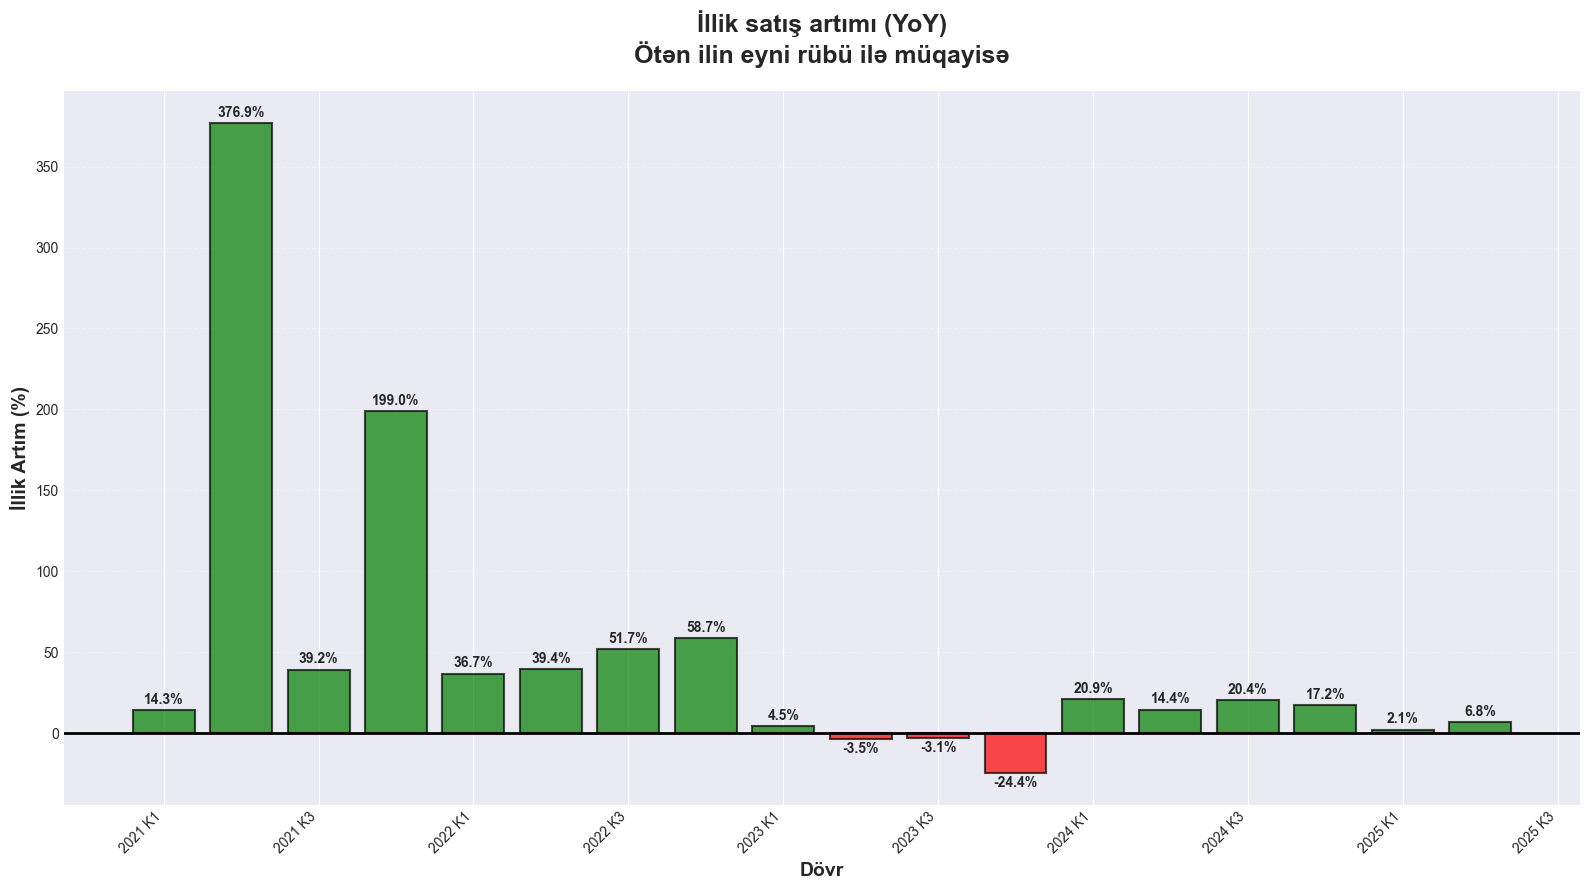

In [48]:
# Chart 21: İllik Artım Sürəti (YoY Growth)
fig, ax = plt.subplots(figsize=(16, 9))

df_growth = df.copy()
df_growth['YoY_Growth'] = 0.0

for idx in df_growth.index:
    year = df_growth.loc[idx, 'Year']
    quarter = df_growth.loc[idx, 'Quarter']
    current_sales = df_growth.loc[idx, 'Nağd_pul_kredit_satışı']
    
    if pd.notna(year) and pd.notna(quarter) and year > 2020:
        prev_year_data = df_growth[(df_growth['Year'] == year - 1) & (df_growth['Quarter'] == quarter)]
        if len(prev_year_data) > 0:
            prev_sales = prev_year_data['Nağd_pul_kredit_satışı'].iloc[0]
            if prev_sales > 0:
                growth = ((current_sales - prev_sales) / prev_sales) * 100
                df_growth.loc[idx, 'YoY_Growth'] = growth

df_growth_filtered = df_growth[df_growth['Year'] > 2020]
x_labels = [f"{int(row['Year'])} K{int(row['Quarter'])}" if pd.notna(row['Year']) else '' 
            for _, row in df_growth_filtered.iterrows()]
x_pos = range(len(df_growth_filtered))

colors = ['green' if val >= 0 else 'red' for val in df_growth_filtered['YoY_Growth']]
bars = ax.bar(x_pos, df_growth_filtered['YoY_Growth'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for i, (bar, val) in enumerate(zip(bars, df_growth_filtered['YoY_Growth'])):
    height = bar.get_height()
    label_y = height + 2 if height > 0 else height - 2
    ax.text(bar.get_x() + bar.get_width()/2., label_y, f'{val:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=10, fontweight='bold')

ax.axhline(y=0, color='black', linewidth=2, linestyle='-')
ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('İllik Artım (%)', fontsize=14, fontweight='bold')
ax.set_title('İllik satış artımı (YoY)\nÖtən ilin eyni rübü ilə müqayisə', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos[::2])
ax.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), 2)], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('images/professional_21_yoy_growth.png', dpi=200, bbox_inches='tight')
plt.show()


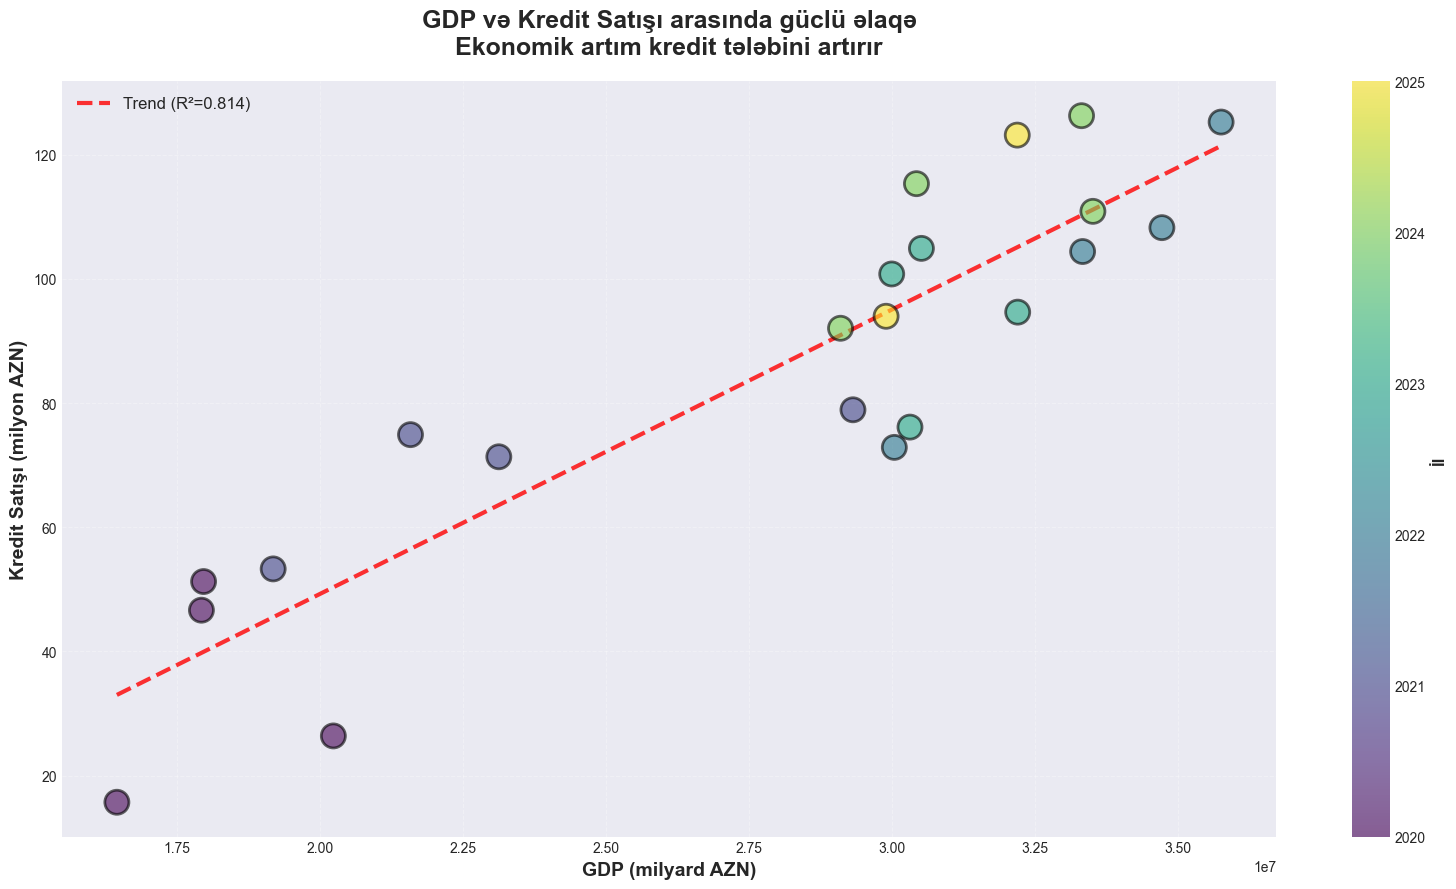

In [49]:
# Chart 22: GDP və Kredit Satışı Əlaqəsi
fig, ax = plt.subplots(figsize=(16, 9))

df_corr = df[df['GDP'].notna() & df['Nağd_pul_kredit_satışı'].notna()].copy()

scatter = ax.scatter(df_corr['GDP'], df_corr['Nağd_pul_kredit_satışı']/1e6, 
                    c=df_corr['Year'], cmap='viridis', s=300, alpha=0.6, 
                    edgecolors='black', linewidth=2, zorder=3)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_corr['GDP'], df_corr['Nağd_pul_kredit_satışı']/1e6)
line_x = np.array([df_corr['GDP'].min(), df_corr['GDP'].max()])
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, 'r--', linewidth=3, alpha=0.8, label=f'Trend (R²={r_value**2:.3f})')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('İl', fontsize=12, fontweight='bold')

ax.set_xlabel('GDP (milyard AZN)', fontsize=14, fontweight='bold')
ax.set_ylabel('Kredit Satışı (milyon AZN)', fontsize=14, fontweight='bold')
ax.set_title('GDP və Kredit Satışı arasında güclü əlaqə\nEkonomik artım kredit tələbini artırır', 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('images/professional_22_gdp_correlation.png', dpi=200, bbox_inches='tight')
plt.show()


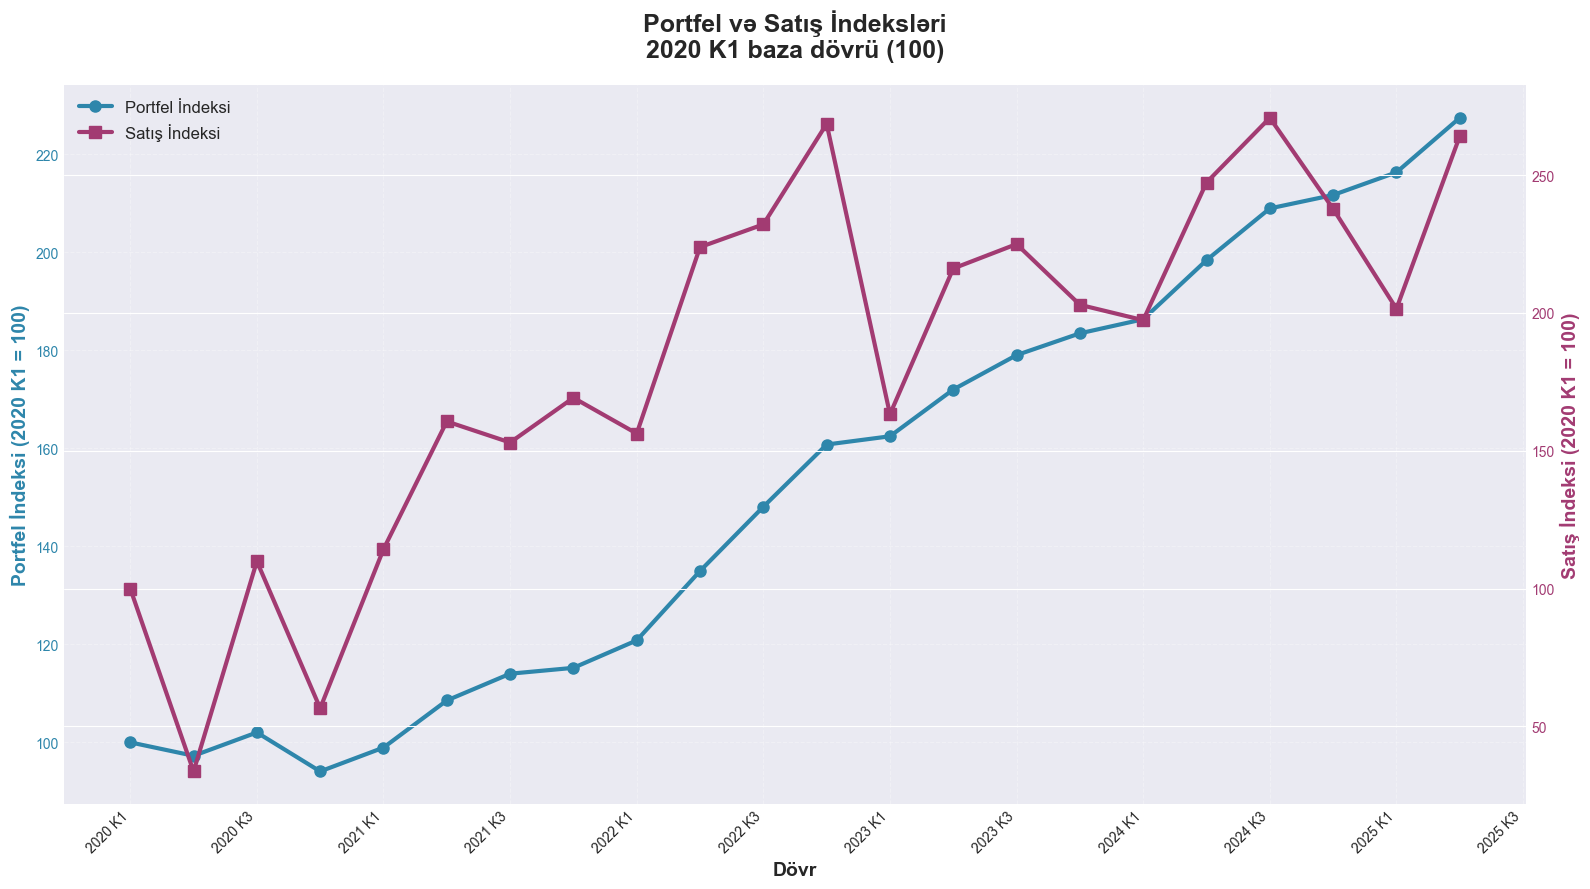

In [50]:
# Chart 23: Portfel və Satış İndeksi
fig, ax1 = plt.subplots(figsize=(16, 9))

df_idx = df.copy()
base_portfolio = df_idx['Portfel'].iloc[0] if len(df_idx) > 0 else 1
base_sales = df_idx['Nağd_pul_kredit_satışı'].iloc[0] if len(df_idx) > 0 else 1

df_idx['Portfolio_Index'] = (df_idx['Portfel'] / base_portfolio) * 100
df_idx['Sales_Index'] = (df_idx['Nağd_pul_kredit_satışı'] / base_sales) * 100

x_labels = [f"{int(row['Year'])} K{int(row['Quarter'])}" if pd.notna(row['Year']) else '' 
            for _, row in df_idx.iterrows()]
x_pos = range(len(df_idx))

color1 = '#2E86AB'
ax1.plot(x_pos, df_idx['Portfolio_Index'], color=color1, linewidth=3, 
         marker='o', markersize=8, label='Portfel İndeksi', zorder=3)
ax1.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfel İndeksi (2020 K1 = 100)', fontsize=14, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.plot(x_pos, df_idx['Sales_Index'], color=color2, linewidth=3, 
         marker='s', markersize=8, label='Satış İndeksi', zorder=3)
ax2.set_ylabel('Satış İndeksi (2020 K1 = 100)', fontsize=14, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title('Portfel və Satış İndeksləri\n2020 K1 baza dövrü (100)', 
             fontsize=18, fontweight='bold', pad=20)
ax1.set_xticks(x_pos[::2])
ax1.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), 2)], rotation=45, ha='right')
ax1.grid(True, alpha=0.3, linestyle='--')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('images/professional_23_index.png', dpi=200, bbox_inches='tight')
plt.show()


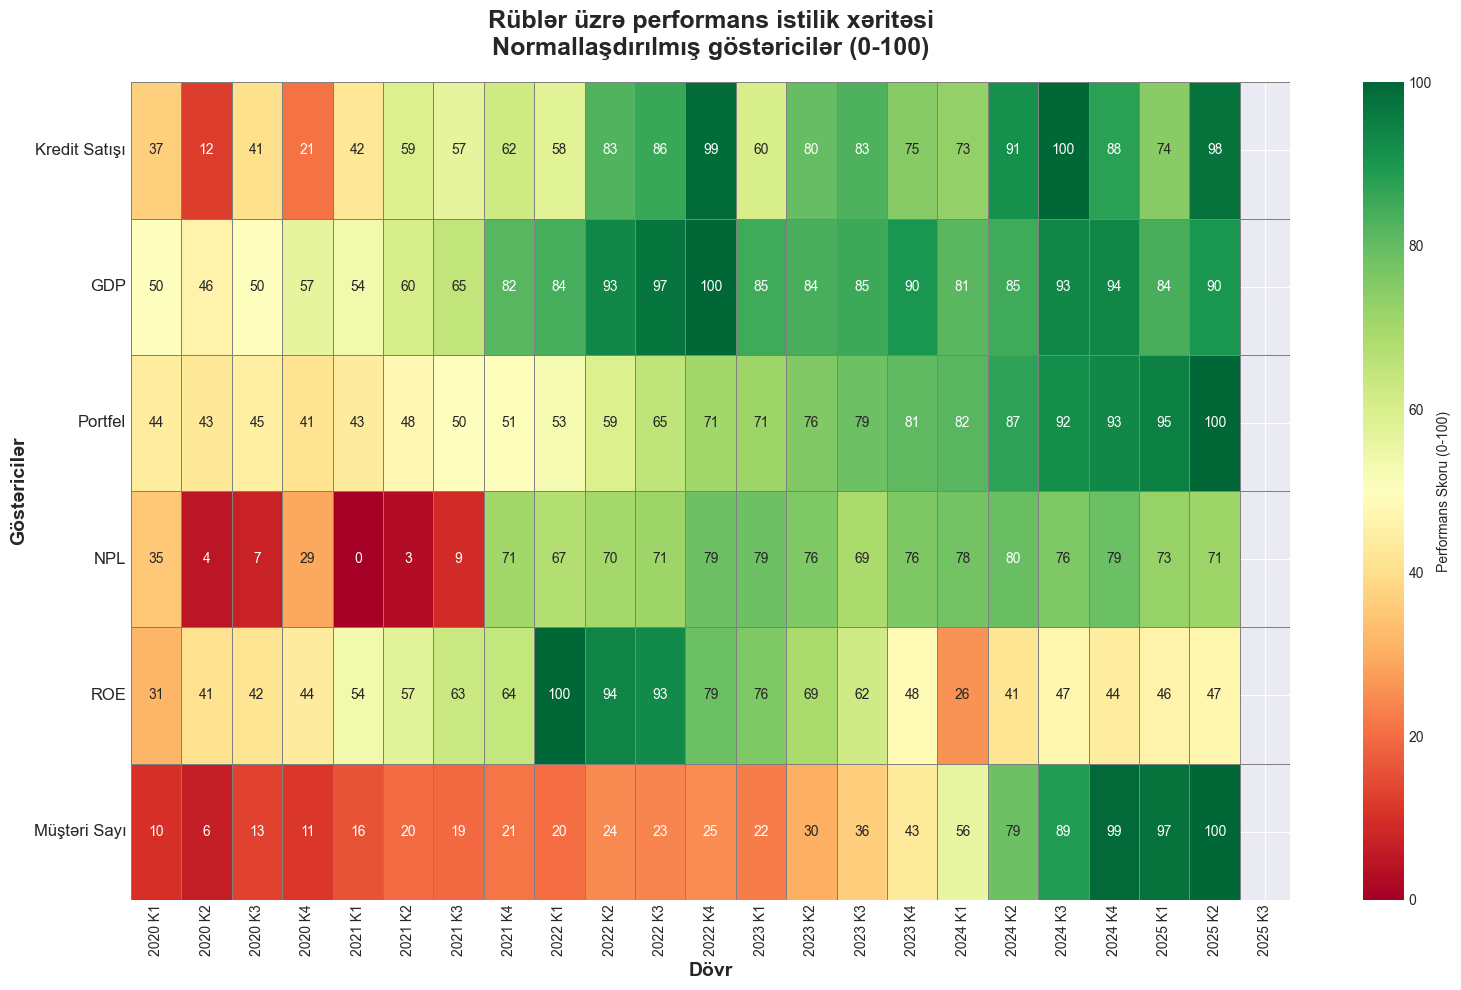

In [51]:
# Chart 24: Əsas Göstəricilərin İstilik Xəritəsi
indicators = ['Nağd_pul_kredit_satışı', 'GDP', 'Portfel', 'NPL_percentage', 'ROE', 'Müştəri_sayı']
df_heat = df[indicators + ['Year', 'Quarter']].copy()

for idx in df_heat.index:
    quarter = df_heat.loc[idx, 'Quarter']
    roe = df_heat.loc[idx, 'ROE']
    if pd.notna(roe) and pd.notna(quarter):
        if quarter == 1:
            df_heat.loc[idx, 'ROE'] = roe * 4
        elif quarter == 2:
            df_heat.loc[idx, 'ROE'] = roe * 2
        elif quarter == 3:
            df_heat.loc[idx, 'ROE'] = roe * (4/3)

df_heat['Period'] = df_heat.apply(lambda row: f"{int(row['Year'])} K{int(row['Quarter'])}" 
                                   if pd.notna(row['Year']) else '', axis=1)
df_heat = df_heat.set_index('Period')
df_heat = df_heat[indicators]

df_normalized = df_heat.copy()
for col in df_normalized.columns:
    if col == 'NPL_percentage':
        df_normalized[col] = 100 - (df_normalized[col] / df_normalized[col].max() * 100)
    else:
        df_normalized[col] = (df_normalized[col] / df_normalized[col].max() * 100)

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_normalized.T, annot=True, fmt='.0f', cmap='RdYlGn', 
            cbar_kws={'label': 'Performans Skoru (0-100)'}, 
            linewidths=0.5, linecolor='gray', ax=ax, vmin=0, vmax=100)

ax.set_title('Rüblər üzrə performans istilik xəritəsi\nNormallaşdırılmış göstəricilər (0-100)', 
            fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('Göstəricilər', fontsize=14, fontweight='bold')

labels = ['Kredit Satışı', 'GDP', 'Portfel', 'NPL', 'ROE', 'Müştəri Sayı']
ax.set_yticklabels(labels, rotation=0, fontsize=12)

plt.tight_layout()
plt.savefig('images/professional_24_heatmap_quarters.png', dpi=200, bbox_inches='tight')
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


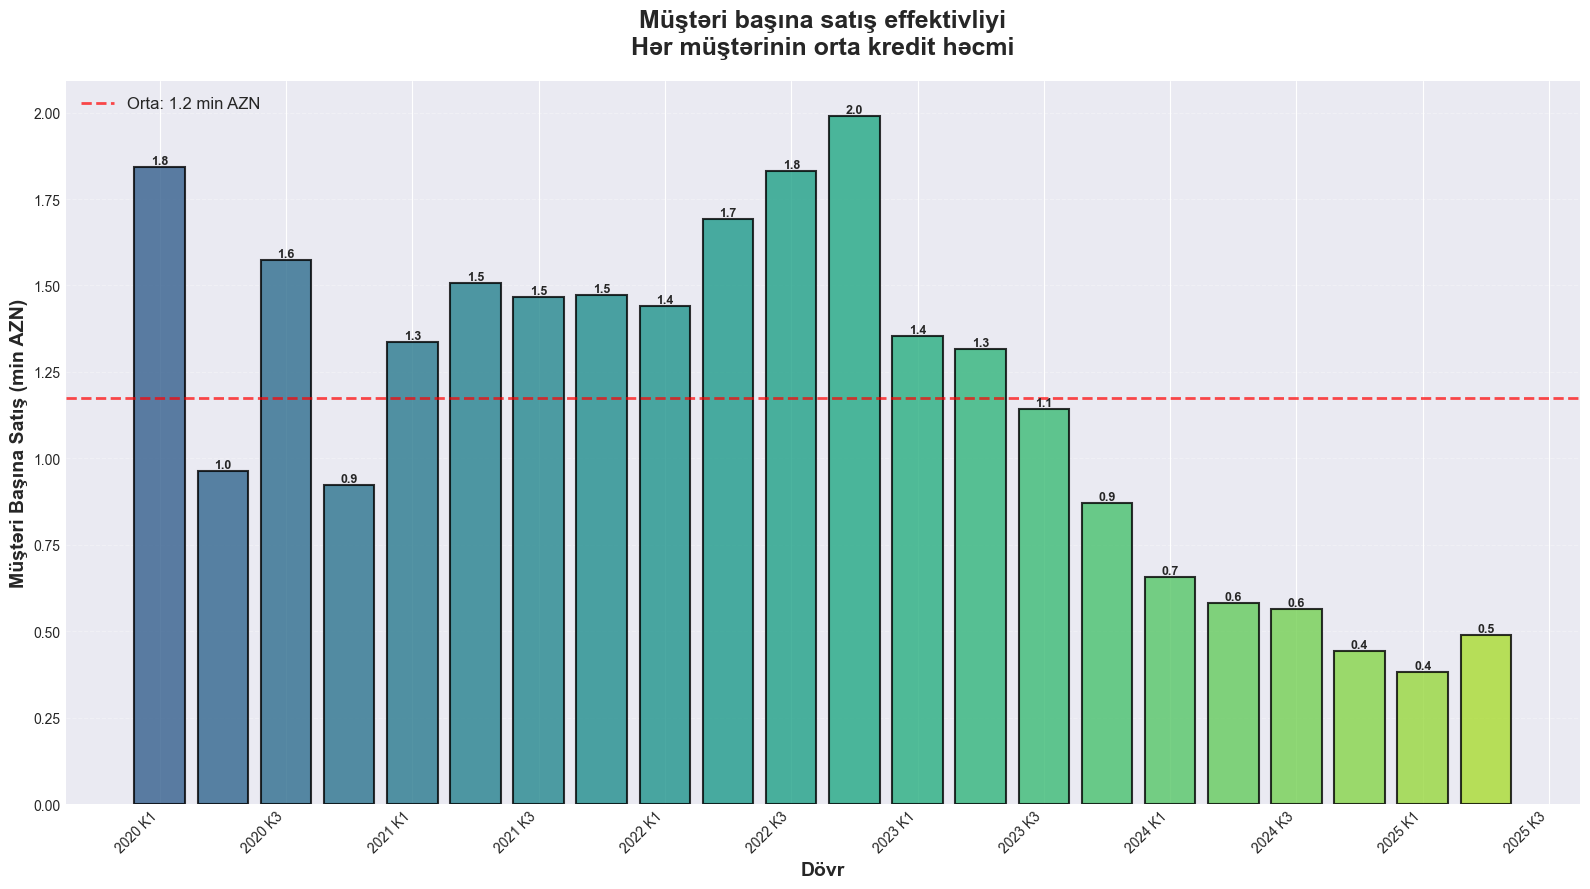

In [52]:
# Chart 25: Müştəri Başına Satış Effektivliyi
fig, ax = plt.subplots(figsize=(16, 9))

df_eff = df.copy()
df_eff['Sales_per_Customer'] = (df_eff['Nağd_pul_kredit_satışı'] / df_eff['Müştəri_sayı']) / 1000

x_labels = [f"{int(row['Year'])} K{int(row['Quarter'])}" if pd.notna(row['Year']) else '' 
            for _, row in df_eff.iterrows()]
x_pos = range(len(df_eff))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_eff)))
bars = ax.bar(x_pos, df_eff['Sales_per_Customer'], color=colors, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, df_eff['Sales_per_Customer']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

avg_efficiency = df_eff['Sales_per_Customer'].mean()
ax.axhline(y=avg_efficiency, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Orta: {avg_efficiency:.1f} min AZN')

ax.set_xlabel('Dövr', fontsize=14, fontweight='bold')
ax.set_ylabel('Müştəri Başına Satış (min AZN)', fontsize=14, fontweight='bold')
ax.set_title('Müştəri başına satış effektivliyi\nHər müştərinin orta kredit həcmi', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos[::2])
ax.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), 2)], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('images/professional_25_efficiency.png', dpi=200, bbox_inches='tight')
plt.show()
